<a href="https://colab.research.google.com/github/Praneeth-18/Regression-MLP-and-Latent-Manifolds/blob/main/regression_and_latent_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Buisness Objective

We need to update uber's fare prediction model, to account for inflation.

Assumption: We have dataset which includes data from 2009 to 2015 , and we synthetically generated data from 2016 to 2017. Each year the fair increase by certain amount, however based on our data which is only till 2017, we say the algorithm hasn't been updated since 2017, and we want to update the algorithm to account for it, so that uber can run its operations successfully in 2024.

Ourprocess: We have existing fare for trip, for each trip we will increase the fair price by 2.5% per year, this is what we expect the current rides to cost.

Firstly we will try out things on just the on data from 2009 to 2015 and then we will run the Muller's Loop on the the entire datasets


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
import seaborn as sns
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
uber = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/uber_clean_preclustering_datetime_split.csv')

In [ ]:
uber.head()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          7.5        -73.999817        40.738354         -73.999512   
1          7.7        -73.994355        40.728225         -73.994710   
2         12.9        -74.005043        40.740770         -73.962565   
3          5.3        -73.976124        40.790844         -73.965316   
4         16.0        -73.925023        40.744085         -73.973082   

   dropoff_latitude  passenger_count  euclidean_distance        date  \
0         40.723217              1.0            0.015140  2015-05-07   
1         40.750325              1.0            0.022103  2009-07-17   
2         40.772647              1.0            0.053109  2009-08-24   
3         40.803349              3.0            0.016528  2009-06-26   
4         40.761247              5.0            0.051031  2014-08-28   

                  time  day_of_week  haversine_distance_km  year  month  day  \
0  1900-01-01 19:52:06            3               1.683323  2015      5    7   
1  1900-01-01 20:04:56            4               2.457590  2009      7   17   
2  1900-01-01 21:45:00            0               5.036377  2009      8   24   
3  1900-01-01 08:22:21            4               1.661683  2009      6   26   
4  1900-01-01 17:47:00            3               4.475450  2014      8   28   

   hour  minutes  seconds  
0    19       52        6  
1    20        4       56  
2    21       45        0  
3     8       22       21  
4    17       47        0

# Outlier Detection and Removal

In [ ]:
!pip install pyod

In [ ]:
#code generated by chatGPT
import pandas as pd
from pyod.models.knn import KNN   # Import KNN model for outlier detection

# Assuming 'df' is your DataFrame and 'feature_columns' is a list of feature column names
X = uber.drop(['year','date','time','seconds','minutes'],axis=1)

# Initialize the KNN model for outlier detection
clf = KNN()

# Fit the model on the data
clf.fit(X)

# Get the outlier scores for each data point
outlier_scores = clf.decision_scores_

# You can use a threshold to classify data points as outliers or inliers
# For example, let's use the mean of the outlier scores as the threshold
threshold = outlier_scores.mean()

# Mark data points as outliers if their scores are greater than the threshold
is_outlier = outlier_scores > threshold

# Filter out the outliers from the DataFrame
cleaned_uber = uber[~is_outlier]

print(f"Original DataFrame size: {uber.shape}")
print(f"Cleaned DataFrame size: {cleaned_uber.shape}")


Original DataFrame size: (26243, 17)
Cleaned DataFrame size: (17672, 17)


# Regression Based on each features

In [ ]:

#function used for adjusting the price as per inflation
def adjust_fare_inflation(df,inflation=0.025):
  # Current year
  current_year = datetime.datetime.now().year
  # Calculate the difference in years and update the fare
  df['updated_fare_amount'] = df.apply(lambda row: row['fare_amount'] * (1 + inflation) ** (current_year - row['year']), axis=1)

In [ ]:
adjust_fare_inflation(cleaned_uber)
#getting rid of the old fare amount
adjusted_uber = cleaned_uber.drop('fare_amount',axis=1)

<ipython-input-5-a3f9af266299>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['updated_fare_amount'] = df.apply(lambda row: row['fare_amount'] * (1 + inflation) ** (current_year - row['year']), axis=1)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

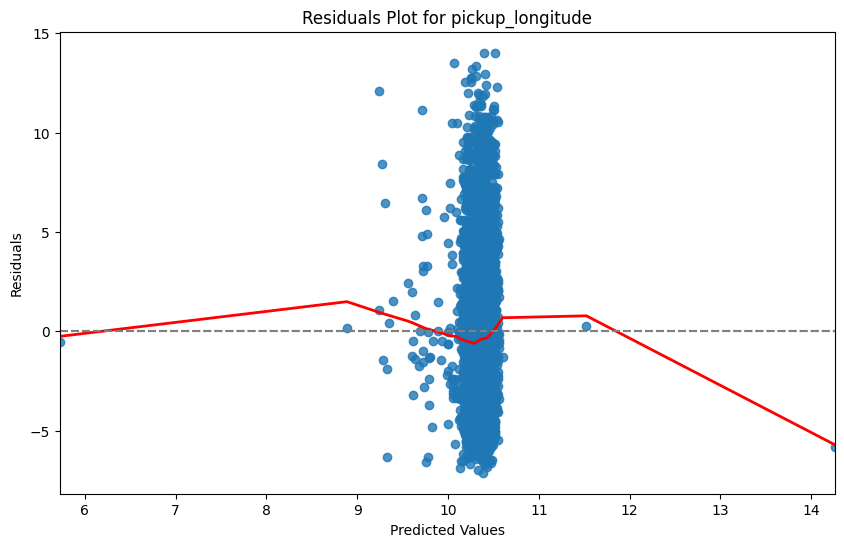

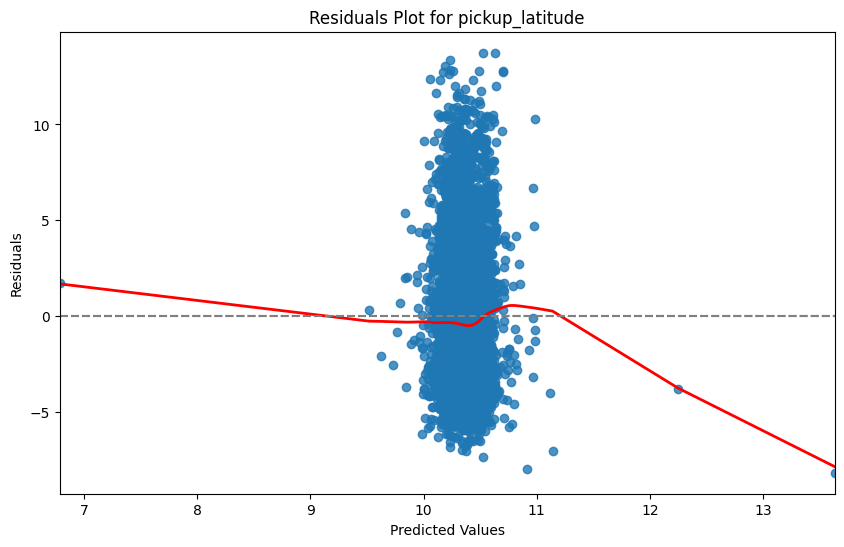

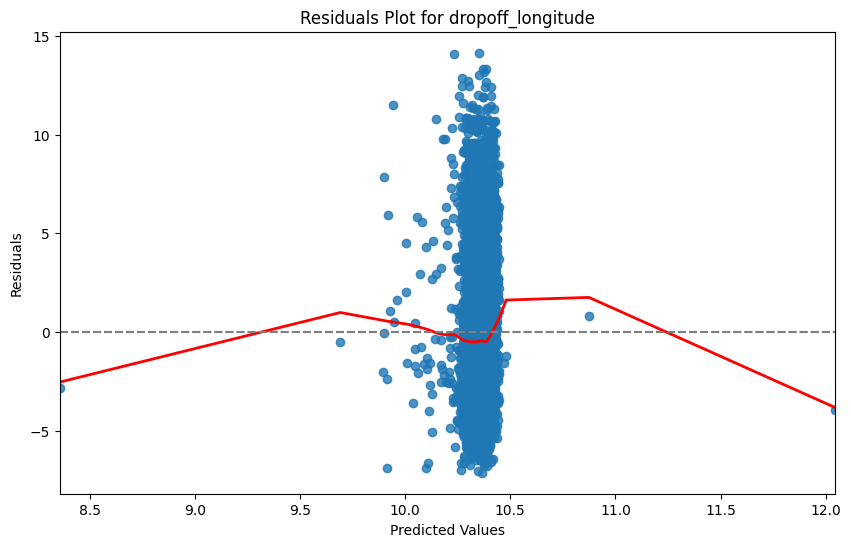

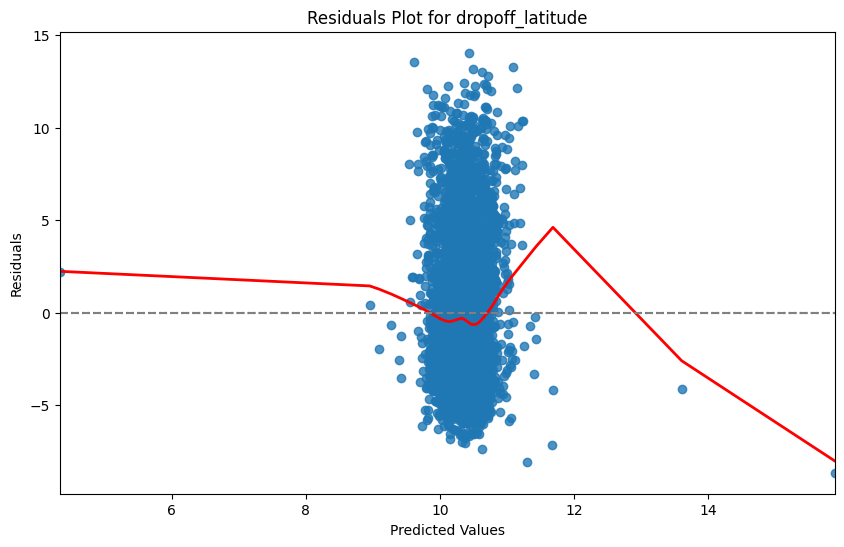

/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


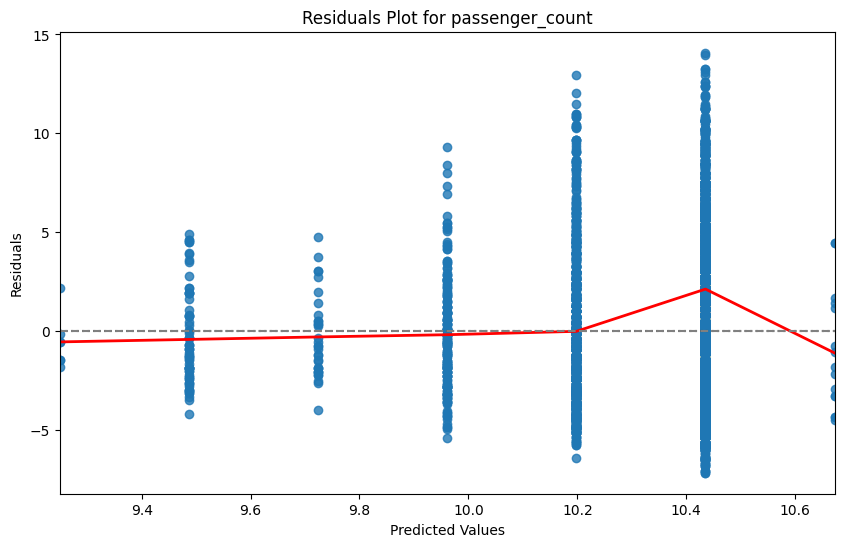

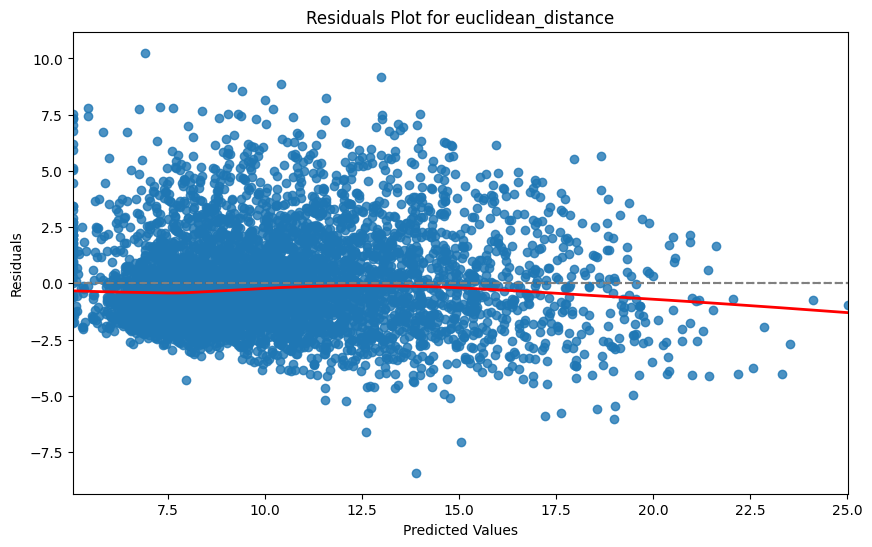

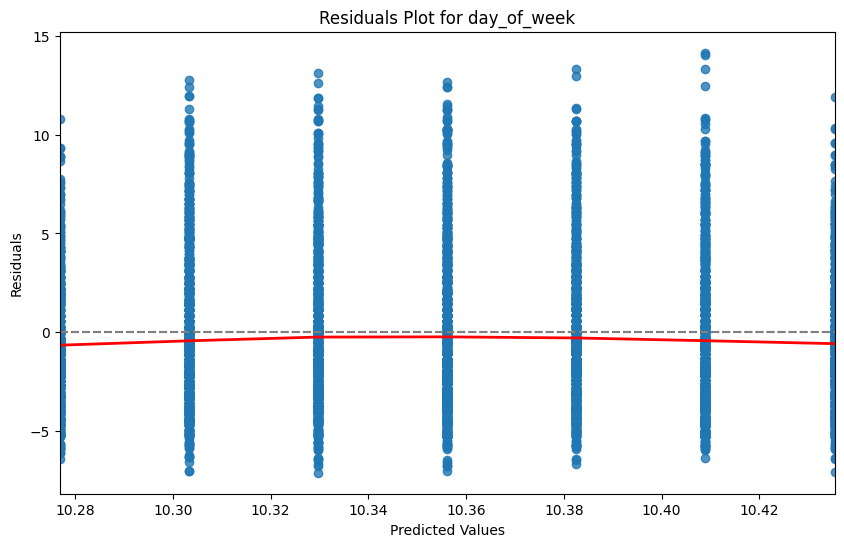

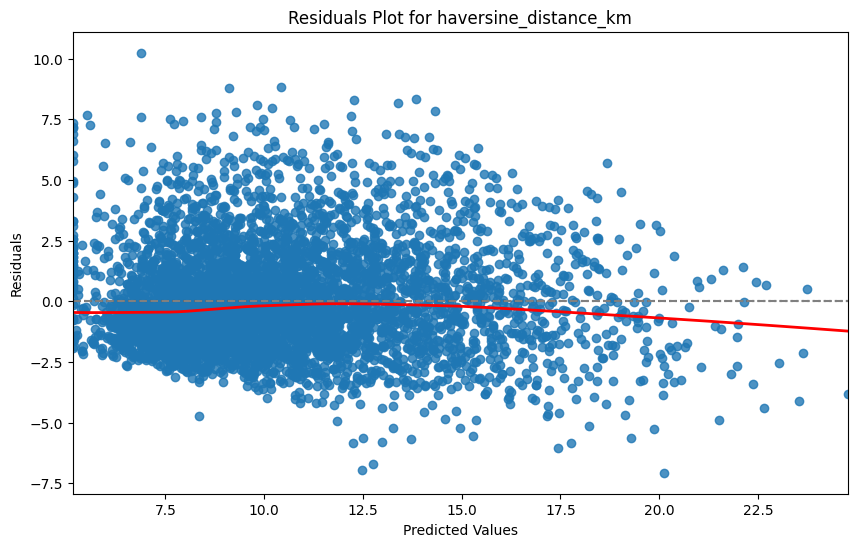

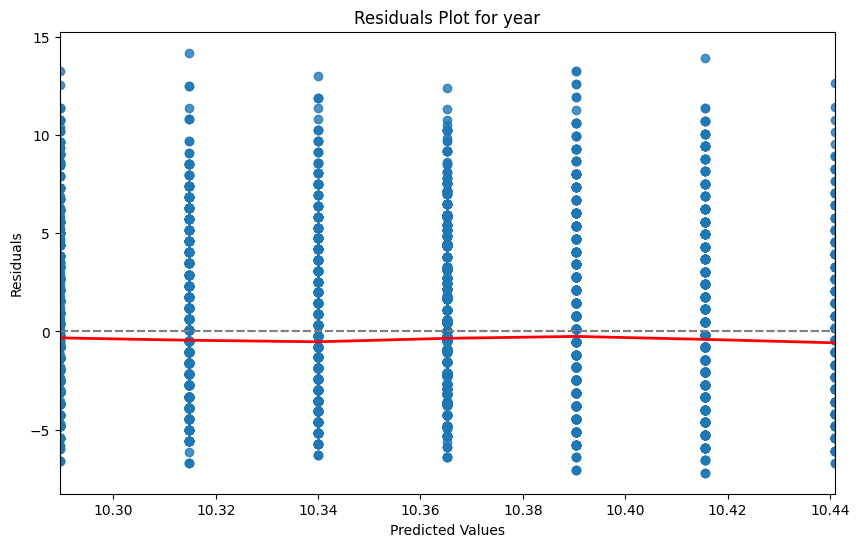

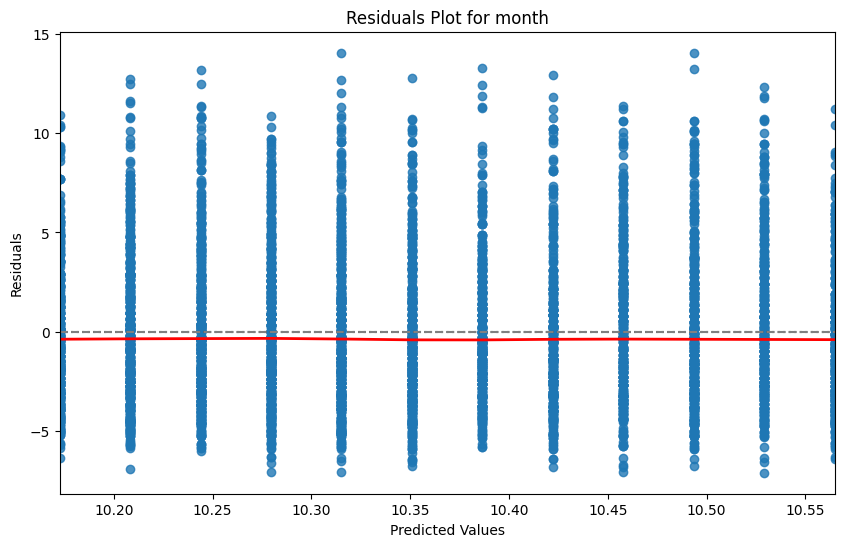

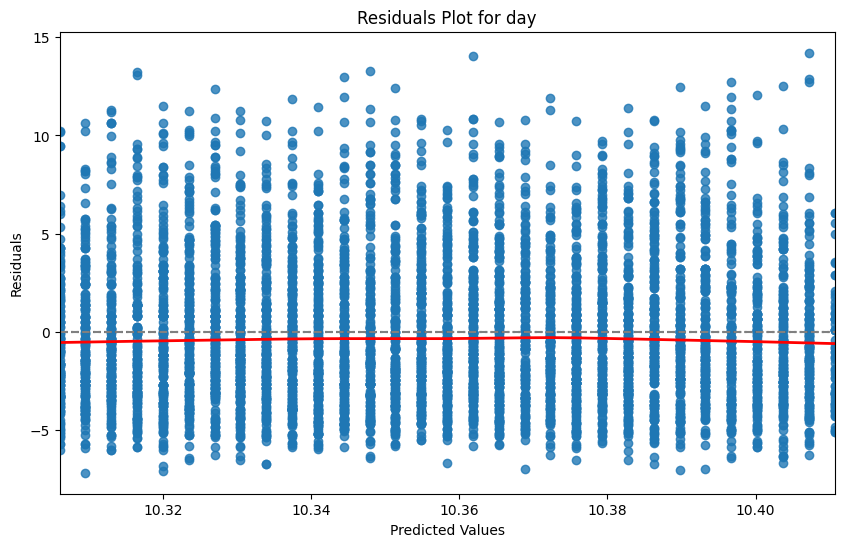

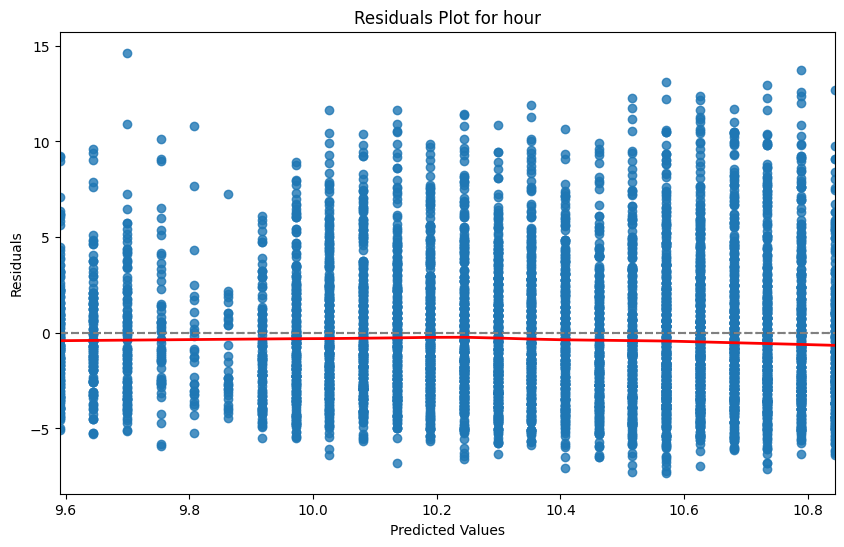

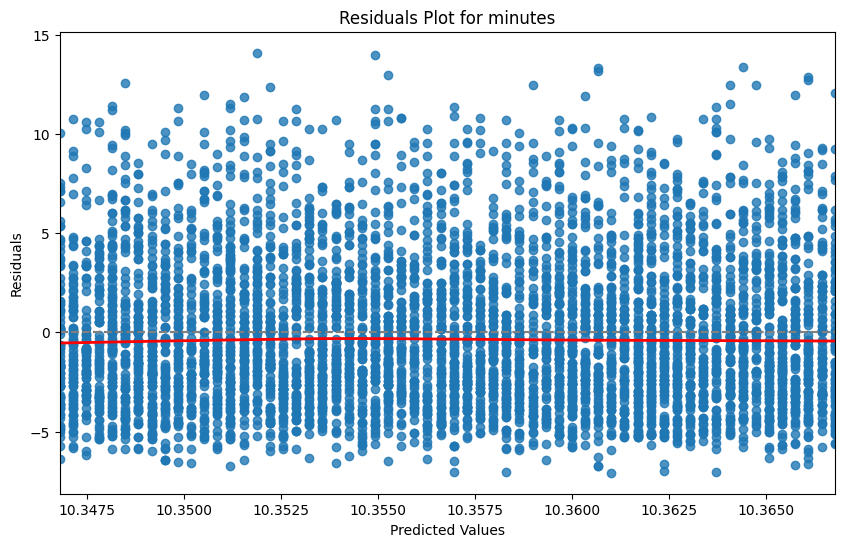

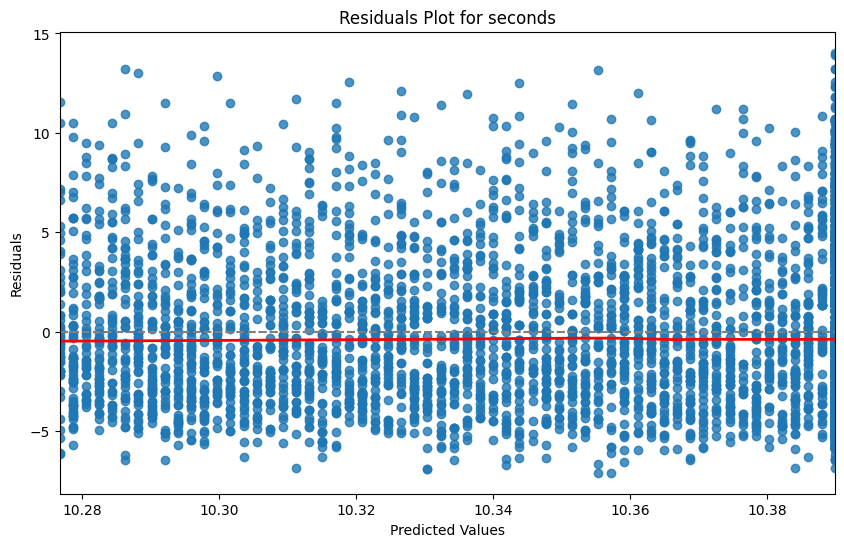

In [ ]:
features= adjusted_uber.drop(['date','time','updated_fare_amount'],axis=1)
for feature in features:
    # Prepare the data
    X = adjusted_uber[[feature]]  # Selecting one feature at a time
    y = adjusted_uber['updated_fare_amount']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Build the regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Plot the residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
    plt.title(f'Residuals Plot for {feature}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.show()



We have updated all trips to reflect the what the price would have been if the trip happened in year 2024. So will treat all trips as if they happened in the same year.

Additionally based on the buisness logic and our fractal clustering analysis the fare of the trip depends on time of the day, but not at the seconds level.

In [ ]:
#Dropping year, updated_fare_amount, date and time
X = adjusted_uber.drop(['year','updated_fare_amount','date','time','seconds','minutes'],axis=1)
y = adjusted_uber['updated_fare_amount']

In [ ]:

print(np.max(y))
print(np.min(y))

33.22211618094415
3.122157424869163


<Axes: >

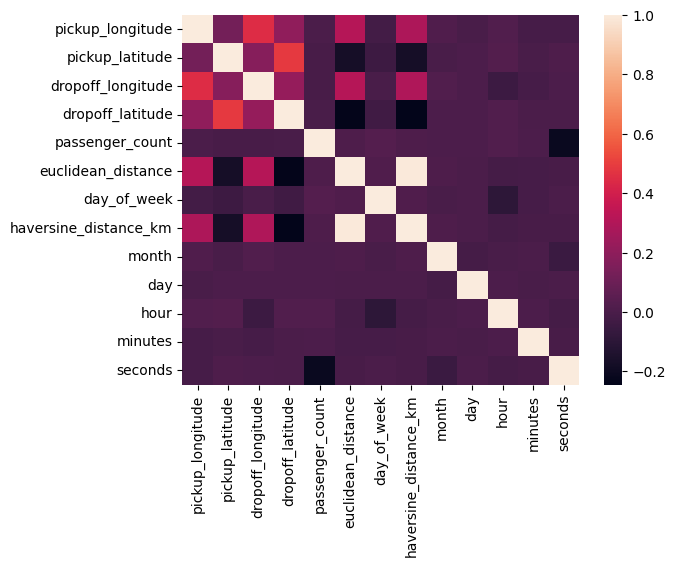

In [ ]:
import seaborn as sns
sns.heatmap(X.corr())

Haversine distance and Euclidean distance have high correlation with each other, this can cause problems down the line. Let us build a sample model and from its feature importance we can decide which one to keep

# Base Regression

In [ ]:
def plot_res_reg(y_test,y_pred):
  residuals = y_test - y_pred
  plt.figure(figsize=(10, 6))
  sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
  plt.title('Residuals Plot')
  plt.xlabel('Predicted Values')
  plt.ylabel('Residuals')
  plt.axhline(y=0, color='grey', linestyle='--')
  plt.show()

  # Visualize the model fit
  plt.figure(figsize=(10, 6))
  plt.scatter(y_test, y_pred, alpha=0.5)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
  plt.title('Actual vs. Predicted Values')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.show()

In [ ]:
#Performing Standard scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X)

Let us build a simple linear regression model to get a starting point and understanding the feature importance.

In [ ]:


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
# Initialize the linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# <ake prediction
y_pred = model.predict(X_test)

In [ ]:
def evaluate_regression_model(y_test,y_pred):
  # Evaluating the model using different techniques
  # Calculate metrics
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)


  # Print metrics
  print(f"Mean Squared Error (MSE): {mse:f}")
  print(f"Mean Absolute Error (MAE): {mae:f}")
  print(f"R-squared (R2): {r2:f}")


In [ ]:
evaluate_regression_model(y_test,y_pred)

Mean Squared Error (MSE): 4.385436
Mean Absolute Error (MAE): 1.613251
R-squared (R2): 0.688451


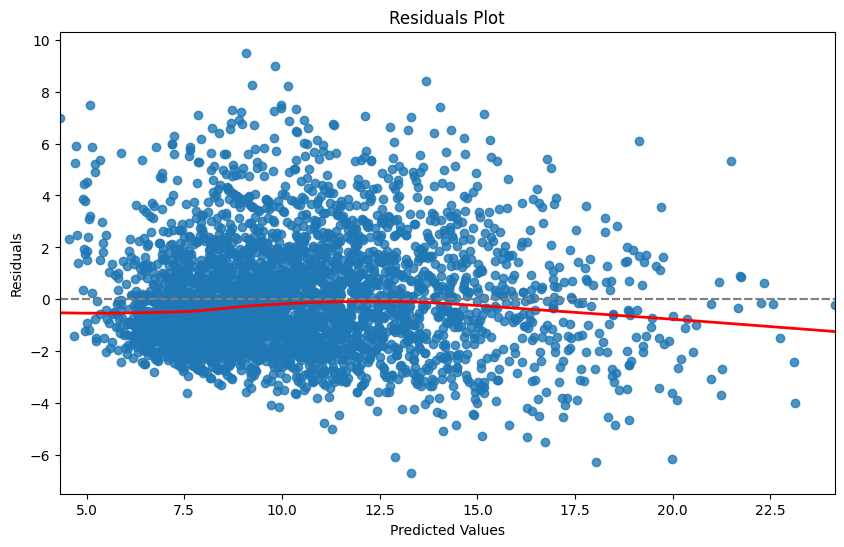

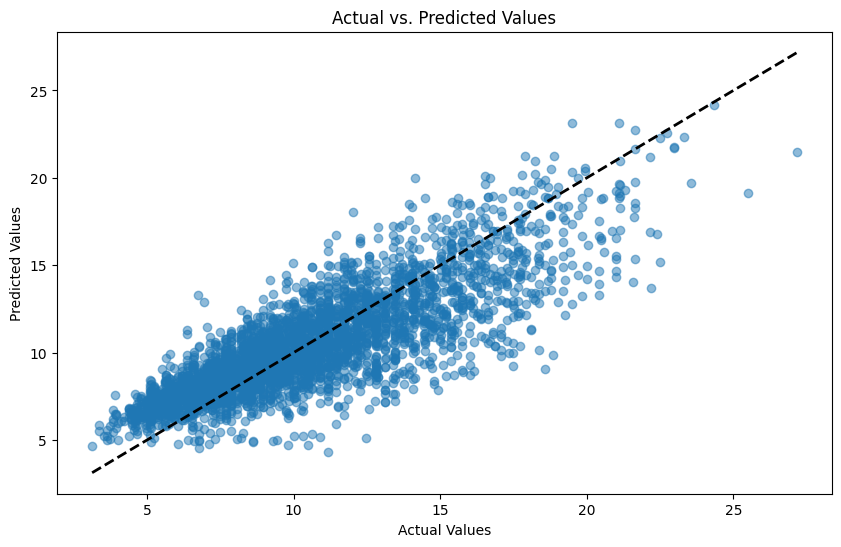

In [ ]:
plot_res_reg(y_test,y_pred)

Extracting feature Importance from the base model

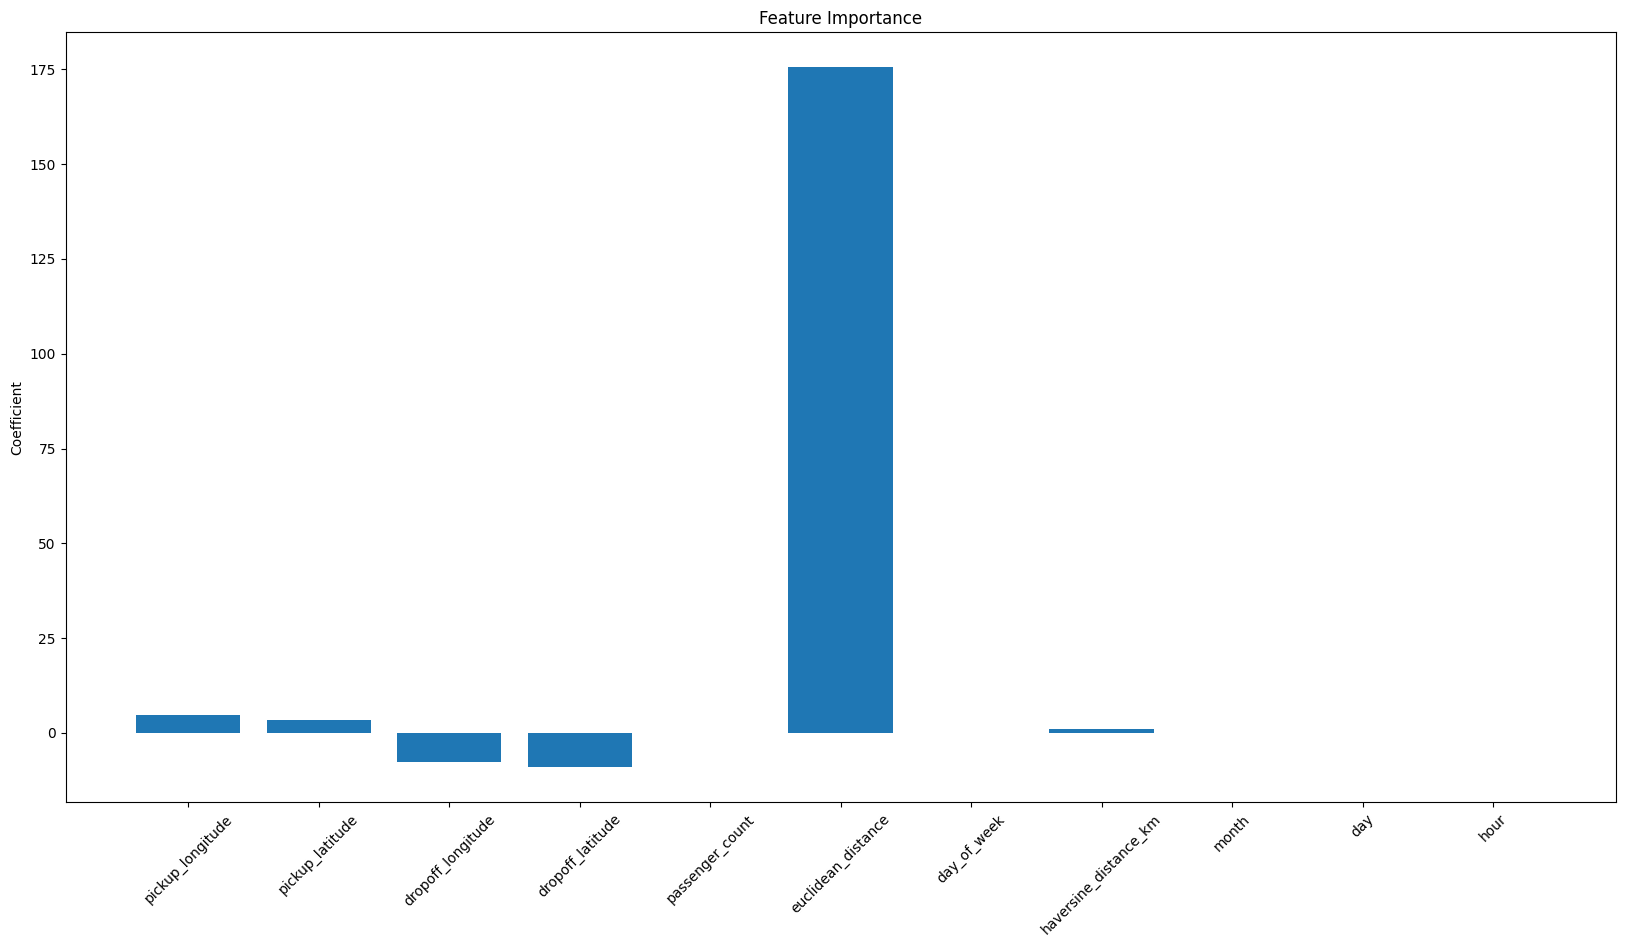

In [ ]:
import matplotlib.pyplot as plt

# Plot the coefficient
plt.figure(figsize=(20,10))
plt.bar(X.columns, model.coef_)
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.title('Feature Importance')
plt.show()

We can see for linear regression, that there are some features that donot have a significant importance.

Let us Try to remove some of the less important features to see if we can improve the model performance.

In [ ]:
#Dropping year, updated_fare_amount, date and time
X = adjusted_uber.drop(['year','updated_fare_amount','date','time','passenger_count','day_of_week','month','day','hour','minutes','seconds'],axis=1)
y = adjusted_uber['updated_fare_amount']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
# Initialize the linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# <ake prediction
y_pred = model.predict(X_test)
evaluate_regression_model(y_test,y_pred)

Mean Squared Error (MSE): 4.440552
Mean Absolute Error (MAE): 1.623602
R-squared (R2): 0.684536


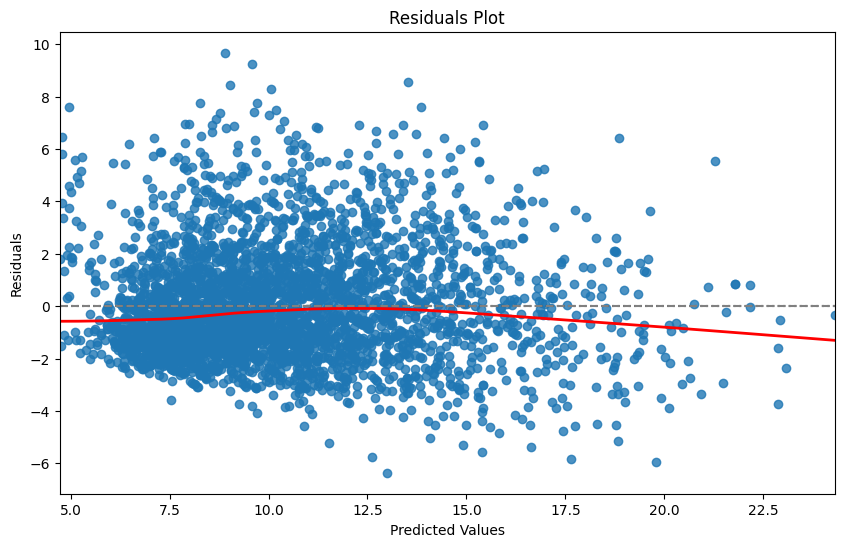

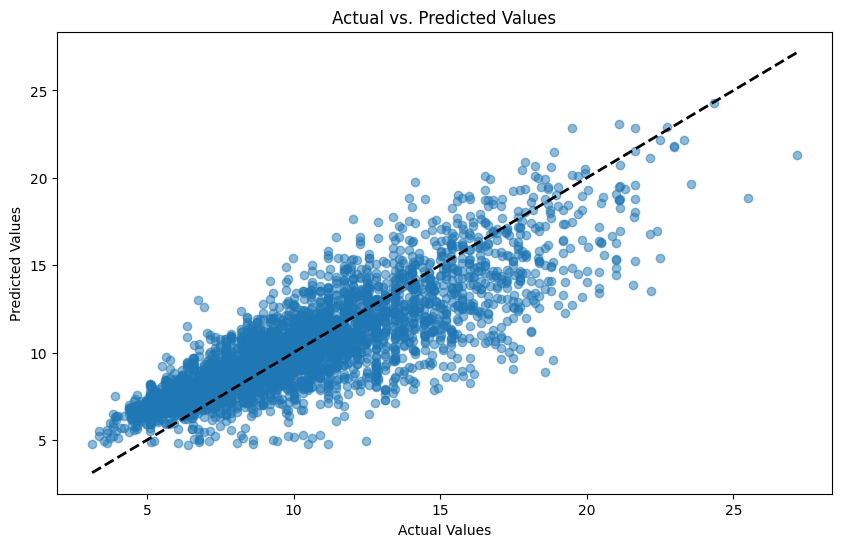

In [ ]:
plot_res_reg(y_test,y_pred)

After removing the less importance features forinear regression we weren't able to increase improve the preformance by Much

Let us try using different set of features. Logically thinking based on the features we have, the fare of trip should depend on the distance between the pick up and destination and the time of day (which would represent the traffic)

In [ ]:
#Dropping year, updated_fare_amount, date and time
X = adjusted_uber[['euclidean_distance','haversine_distance_km','hour','month']]
y = adjusted_uber['updated_fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
# Initialize the linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# <ake prediction
y_pred = model.predict(X_test)
evaluate_regression_model(y_test,y_pred)

Mean Squared Error (MSE): 4.455292
Mean Absolute Error (MAE): 1.624719
R-squared (R2): 0.683489


Let Us Now try to Include som Latent Variables to improve the performance.

#Latent Features: Number of Rides at the same time

As https://www.uber.com/en-GB/blog/uber-dynamic-pricing/ we can say the fare has a direct relation with the number of rides at that moment.


## Data Engineering

In [ ]:
adjusted_uber.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.999817        40.738354         -73.999512         40.723217   
1        -73.994355        40.728225         -73.994710         40.750325   
2        -74.005043        40.740770         -73.962565         40.772647   
3        -73.976124        40.790844         -73.965316         40.803349   
5        -73.969019        40.755910         -73.969019         40.755910   

   passenger_count  euclidean_distance        date                 time  \
0              1.0            0.015140  2015-05-07  1900-01-01 19:52:06   
1              1.0            0.022103  2009-07-17  1900-01-01 20:04:56   
2              1.0            0.053109  2009-08-24  1900-01-01 21:45:00   
3              3.0            0.016528  2009-06-26  1900-01-01 08:22:21   
5              1.0            0.000000  2011-02-12  1900-01-01 02:27:09   

   day_of_week  haversine_distance_km  year  month  day  hour  minutes  \
0            3               1.683323  2015      5    7    19       52   
1            4               2.457590  2009      7   17    20        4   
2            0               5.036377  2009      8   24    21       45   
3            4               1.661683  2009      6   26     8       22   
5            5               0.000000  2011      2   12     2       27   

   seconds  updated_fare_amount  
0        6             9.366472  
1       56            11.151896  
2        0            18.683046  
3       21             7.675980  
5        9             6.754704

In [ ]:
# Group by year, month, day, and hour and count the number of occurrences
group_sizes = adjusted_uber.groupby(['year', 'month', 'day', 'hour']).size().reset_index(name='no_parellel_rides')

# Merge the group size information back into the original DataFrame
adjusted_uber_parellel_rides = pd.merge(adjusted_uber, group_sizes, on=['year', 'month', 'day', 'hour'], how='left')

In [ ]:
adjusted_uber_parellel_rides['no_parellel_rides'].value_counts()

1    11810
2     4590
3     1074
4      172
5       20
6        6
Name: no_parellel_rides, dtype: int64

In [ ]:
# makig sure we don'thave any na values after a left join
adjusted_uber_parellel_rides.isna().sum().sum()

0

## Fitting a Linear Model

In [ ]:
from sklearn.linear_model import SGDRegressor

In [ ]:

from sklearn.preprocessing import StandardScaler

In [ ]:
#Dropping year, updated_fare_amount, date and time
X = adjusted_uber_parellel_rides.drop(['year','updated_fare_amount','date','time','seconds','minutes'],axis=1)
# X = adjusted_uber[['euclidean_distance','haversine_distance_km','hour','month']]
scaler = StandardScaler()
# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X)
y = adjusted_uber_parellel_rides['updated_fare_amount']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)
# Initialize the SDGRegressor
model = SGDRegressor()
# Fit the model on the training data
model.fit(X_train, y_train)
# take prediction
y_pred = model.predict(X_test)
evaluate_regression_model(y_test,y_pred)


Mean Squared Error (MSE): 4.403946
Mean Absolute Error (MAE): 1.615134
R-squared (R2): 0.687136


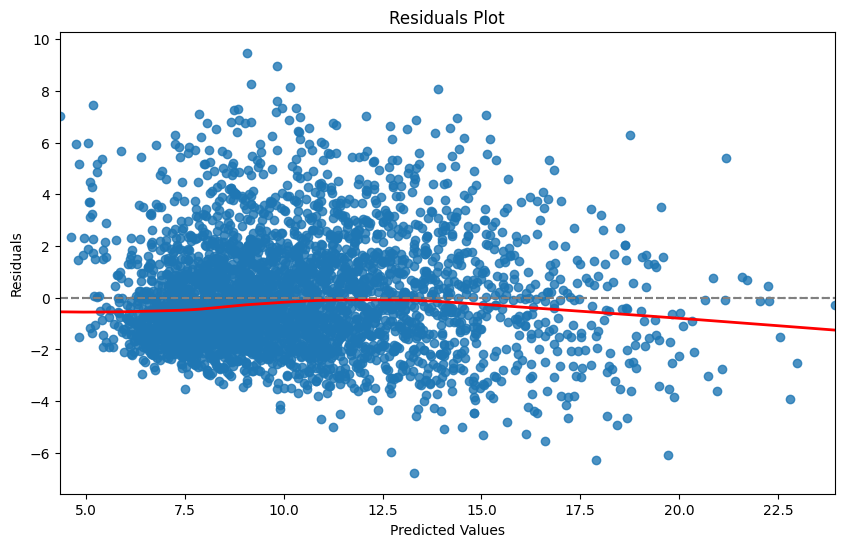

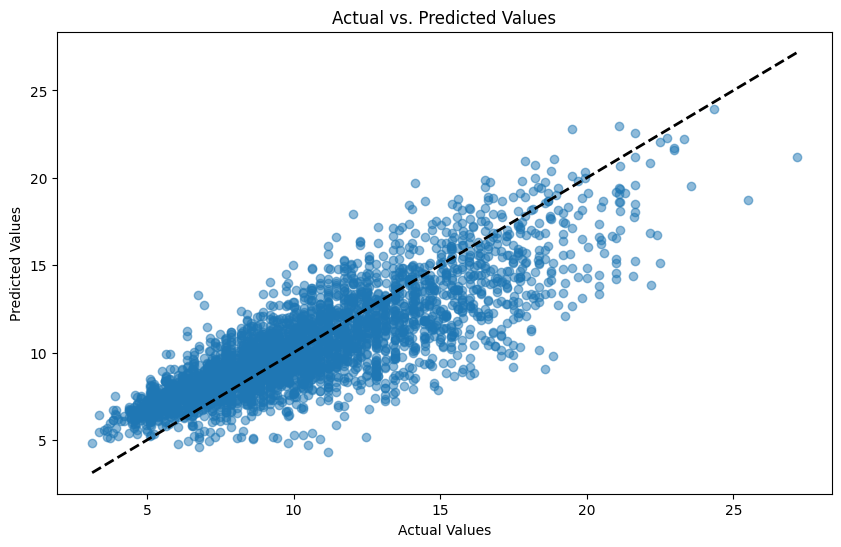

In [ ]:
plot_res_reg(y_test,y_pred)

Our MAE is lower indicating that we are getting closer to the actual value, however our MSE is higher, indicating that when we are far from the truth we are far by a greater than previous model

In [ ]:
import matplotlib.pyplot as plt

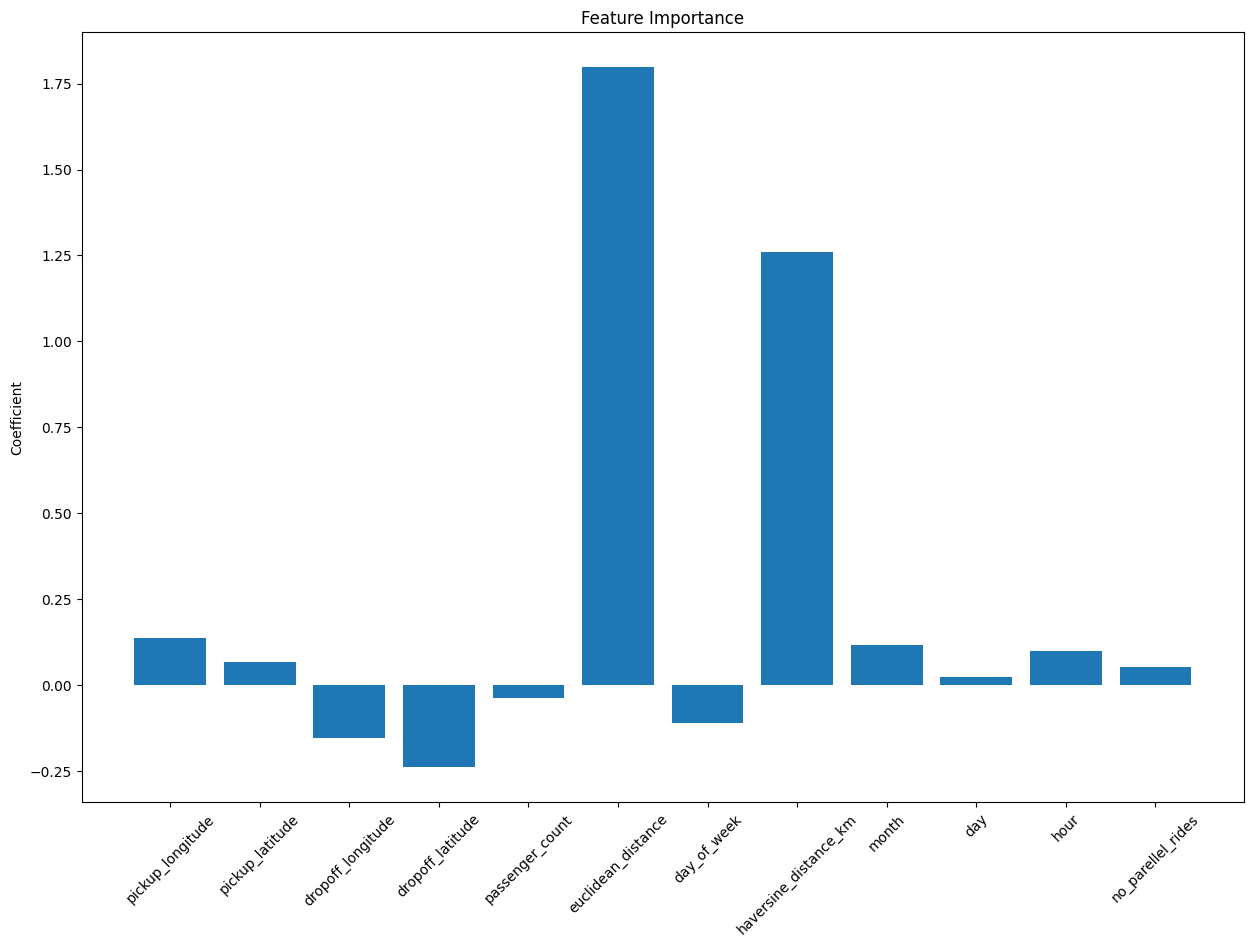

In [ ]:
# Plot the coefficient
plt.figure(figsize=(15,10))
plt.bar(X.columns, model.coef_)
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.title('Feature Importance')
plt.show()

Comapred to using no latent variables, when using the passenger count variable the MSE decreases to 4.4 from 4.5

# Latent Feature: Weather

## Data Engineering

Exploring the NYC weather data from 2009 to 2017

In [ ]:
import pandas as pd

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/New York City,USA 2009-01-01 to 2011-08-31.csv')
df2 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/New York City,USA 2011-09-01 to 2014-04-30.csv')
df3 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/newyork 2014-05-01 to 2015-06-30.csv')
df4 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/New York City 2016-01-01 to 2017-12-31.csv')


In [ ]:
df = pd.concat([df1,df2,df3,df4],axis=0)

In [ ]:
df.shape

(3103, 33)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3103 entries, 0 to 730
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3103 non-null   object 
 1   datetime          3103 non-null   object 
 2   tempmax           3103 non-null   float64
 3   tempmin           3103 non-null   float64
 4   temp              3103 non-null   float64
 5   feelslikemax      3103 non-null   float64
 6   feelslikemin      3103 non-null   float64
 7   feelslike         3103 non-null   float64
 8   dew               3103 non-null   float64
 9   humidity          3103 non-null   float64
 10  precip            3103 non-null   float64
 11  precipprob        3103 non-null   int64  
 12  precipcover       3103 non-null   float64
 13  preciptype        1422 non-null   object 
 14  snow              2677 non-null   float64
 15  snowdepth         2677 non-null   float64
 16  windgust          2215 non-null   float64
 

In [ ]:
df.reset_index(inplace=True,drop=True)

In [ ]:
df.to_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/combined_weather_nyc_2009_2017.csv',index=False)

In [ ]:
df.head()

name    datetime  tempmax  tempmin  temp  feelslikemax  \
0  New York City,USA  2009-01-01     26.1     15.9  20.9          16.5   
1  New York City,USA  2009-01-02     33.7     23.4  30.3          32.1   
2  New York City,USA  2009-01-03     38.3     30.3  33.4          30.2   
3  New York City,USA  2009-01-04     42.0     25.2  33.3          37.2   
4  New York City,USA  2009-01-05     43.3     39.2  41.4          38.7   

   feelslikemin  feelslike   dew  humidity  ...  solarenergy  uvindex  \
0          -0.9        8.1   1.6      43.0  ...          NaN      NaN   
1          17.9       23.9  17.3      59.5  ...          NaN      NaN   
2          19.9       24.5  15.7      48.8  ...          NaN      NaN   
3          15.4       26.2  11.3      40.5  ...          NaN      NaN   
4          33.3       36.4  23.6      49.5  ...          NaN      NaN   

   severerisk              sunrise               sunset  moonphase  \
0         NaN  2009-01-01T07:20:13  2009-01-01T16:39:29       0.18   
1         NaN  2009-01-02T07:20:18  2009-01-02T16:40:20       0.21   
2         NaN  2009-01-03T07:20:21  2009-01-03T16:41:13       0.25   
3         NaN  2009-01-04T07:20:21  2009-01-04T16:42:08       0.25   
4         NaN  2009-01-05T07:20:19  2009-01-05T16:43:04       0.31   

               conditions                                        description  \
0                    Snow  Clear conditions throughout the day with morni...   
1        Partially cloudy                  Partly cloudy throughout the day.   
2                   Clear               Clear conditions throughout the day.   
3        Partially cloudy                  Partly cloudy throughout the day.   
4  Rain, Partially cloudy  Partly cloudy throughout the day with early mo...   

                icon                                           stations  
0               snow  72502594741,72505394728,72502014734,7448609478...  
1  partly-cloudy-day  72502594741,72505394728,72502014734,7448609478...  
2          clear-day  72502594741,72505394728,72502014734,7448609478...  
3  partly-cloudy-day  72502594741,72505394728,72502014734,7448609478...  
4               rain  72502594741,72505394728,72502014734,7448609478...  

[5 rows x 33 columns]

In [ ]:
df.isna().sum()

name                   0
datetime               0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          1681
snow                 426
snowdepth            426
windgust             888
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation       364
solarenergy          364
uvindex              364
severerisk          3103
sunrise                0
sunset                 0
moonphase              0
conditions             0
description            0
icon                   0
stations               0
dtype: int64

In [ ]:
df['icon'].value_counts()

rain                 1266
partly-cloudy-day    1205
clear-day             494
snow                  100
cloudy                 35
fog                     2
wind                    1
Name: icon, dtype: int64

Our Assumption, the fare price on  particular day would also depend on the weather conditions that on that day, on a rainy day more people will travel by cab causing the farprice for a ride to increase.

Based on our assumption we will test our hypothesis by eliminating certain columns which based on our buisness understanding and https://www.tennessean.com/story/money/2016/05/29/surge-pricing-why-rainy-day-ride-cost-you-more/84922758/ we belive wont affect the cost.

To Try Our Hypothesis we will first look at just datetime and icon column (the icon column tells if the day was rainy, cloudy, windy etc)



In [ ]:
df_weather = df[['datetime','icon']]

In [ ]:
df_weather.head()

datetime               icon
0  2009-01-01               snow
1  2009-01-02  partly-cloudy-day
2  2009-01-03          clear-day
3  2009-01-04  partly-cloudy-day
4  2009-01-05               rain

In [ ]:
#performing label encoding on icon
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform the 'icon' column
df_weather['icon_encoded'] = label_encoder.fit_transform(df_weather['icon'])

df_weather2 = df_weather[['datetime','icon_encoded']]


<ipython-input-43-e72635c46bf7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['icon_encoded'] = label_encoder.fit_transform(df_weather['icon'])


In [ ]:
df_weather2 = df_weather2.rename({'datetime':'date'},axis=1)

In [ ]:
adjusted_uber_parellel_rides.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.999817        40.738354         -73.999512         40.723217   
1        -73.994355        40.728225         -73.994710         40.750325   
2        -74.005043        40.740770         -73.962565         40.772647   
3        -73.976124        40.790844         -73.965316         40.803349   
4        -73.969019        40.755910         -73.969019         40.755910   

   passenger_count  euclidean_distance        date                 time  \
0              1.0            0.015140  2015-05-07  1900-01-01 19:52:06   
1              1.0            0.022103  2009-07-17  1900-01-01 20:04:56   
2              1.0            0.053109  2009-08-24  1900-01-01 21:45:00   
3              3.0            0.016528  2009-06-26  1900-01-01 08:22:21   
4              1.0            0.000000  2011-02-12  1900-01-01 02:27:09   

   day_of_week  haversine_distance_km  year  month  day  hour  minutes  \
0            3               1.683323  2015      5    7    19       52   
1            4               2.457590  2009      7   17    20        4   
2            0               5.036377  2009      8   24    21       45   
3            4               1.661683  2009      6   26     8       22   
4            5               0.000000  2011      2   12     2       27   

   seconds  updated_fare_amount  no_parellel_rides  
0        6             9.366472                  4  
1       56            11.151896                  1  
2        0            18.683046                  2  
3       21             7.675980                  2  
4        9             6.754704                  1

Performing a Join on both Data

In [ ]:
# Perform an inner join on the 'date' column
merged_uber_parelle_rides_weather = pd.merge(adjusted_uber_parellel_rides, df_weather2, on='date', how='inner')

In [ ]:
merged_uber_parelle_rides_weather.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.999817        40.738354         -73.999512         40.723217   
1        -73.980225        40.735176         -74.010918         40.701797   
2        -73.972290        40.750214         -73.986351         40.755245   
3        -73.985352        40.768566         -73.992928         40.734158   
4        -73.989372        40.729816         -73.978935         40.744709   

   passenger_count  euclidean_distance        date                 time  \
0              1.0            0.015140  2015-05-07  1900-01-01 19:52:06   
1              1.0            0.045345  2015-05-07  1900-01-01 08:12:06   
2              1.0            0.014934  2015-05-07  1900-01-01 10:46:55   
3              1.0            0.035233  2015-05-07  1900-01-01 22:23:18   
4              1.0            0.018186  2015-05-07  1900-01-01 21:29:50   

   day_of_week  haversine_distance_km  year  month  day  hour  minutes  \
0            3               1.683323  2015      5    7    19       52   
1            3               4.524005  2015      5    7     8       12   
2            3               1.309906  2015      5    7    10       46   
3            3               3.878915  2015      5    7    22       23   
4            3               1.874975  2015      5    7    21       29   

   seconds  updated_fare_amount  no_parellel_rides  icon_encoded  
0        6             9.366472                  4             0  
1        6            15.610787                  1             0  
2       55             9.990904                  1             0  
3       18            16.235219                  2             0  
4       50             8.742041                  2             0

In [ ]:
#making sure we dont have alot of null values
merged_uber_parelle_rides_weather.isna().sum().sum()

0

In [ ]:
merged_uber_parelle_rides_weather['icon_encoded'].value_counts()

3    11173
4     9467
0     4517
5      743
1      323
2       13
6        7
Name: icon_encoded, dtype: int64

## Fitting a Regression Model

Applying regression on after addind the new latent variable

In [ ]:
#Dropping year, updated_fare_amount, date and time
X = merged_uber_parelle_rides_weather.drop(['year','updated_fare_amount','date','time','seconds','minutes'],axis=1)
scaler = StandardScaler()
# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X)
y = merged_uber_parelle_rides_weather['updated_fare_amount']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)
# Initialize the SDGRegressor
model = SGDRegressor()
# Fit the model on the training data
model.fit(X_train, y_train)
# take prediction
y_pred = model.predict(X_test)
evaluate_regression_model(y_test,y_pred)


Mean Squared Error (MSE): 4.311043
Mean Absolute Error (MAE): 1.596176
R-squared (R2): 0.696398


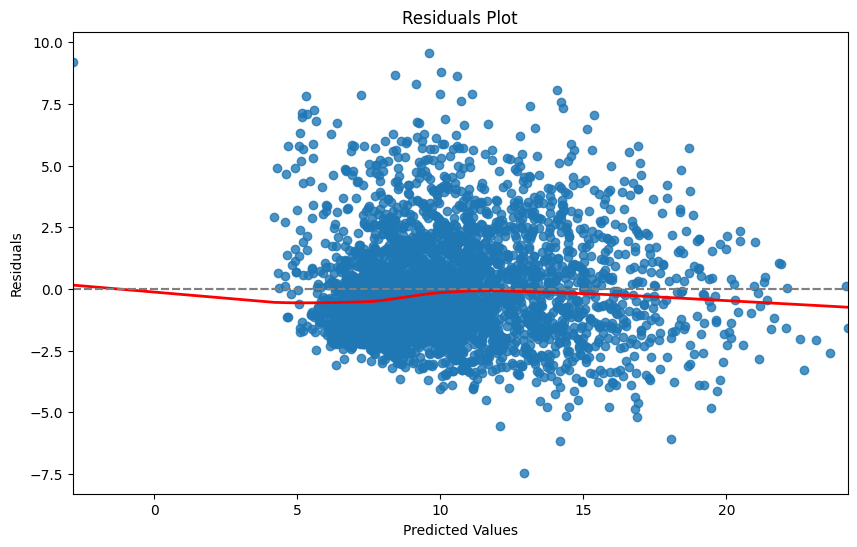

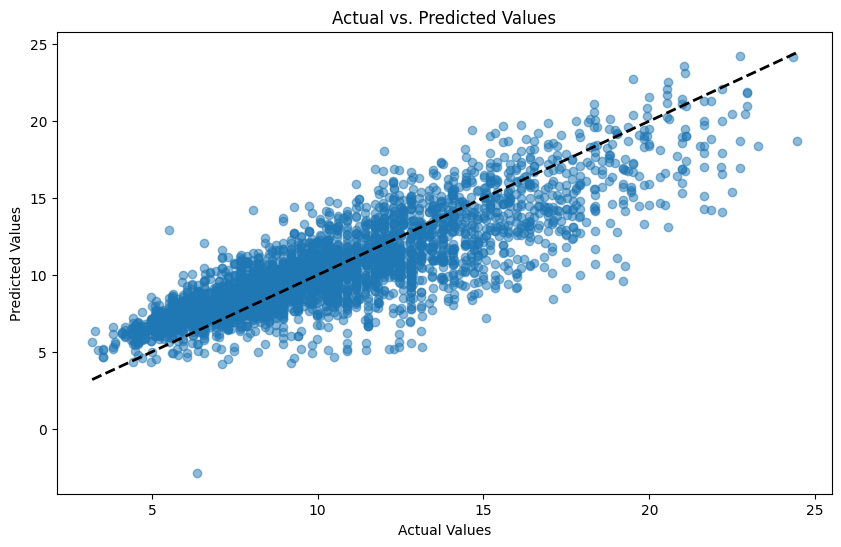

In [ ]:
plot_res_reg(y_test,y_pred)

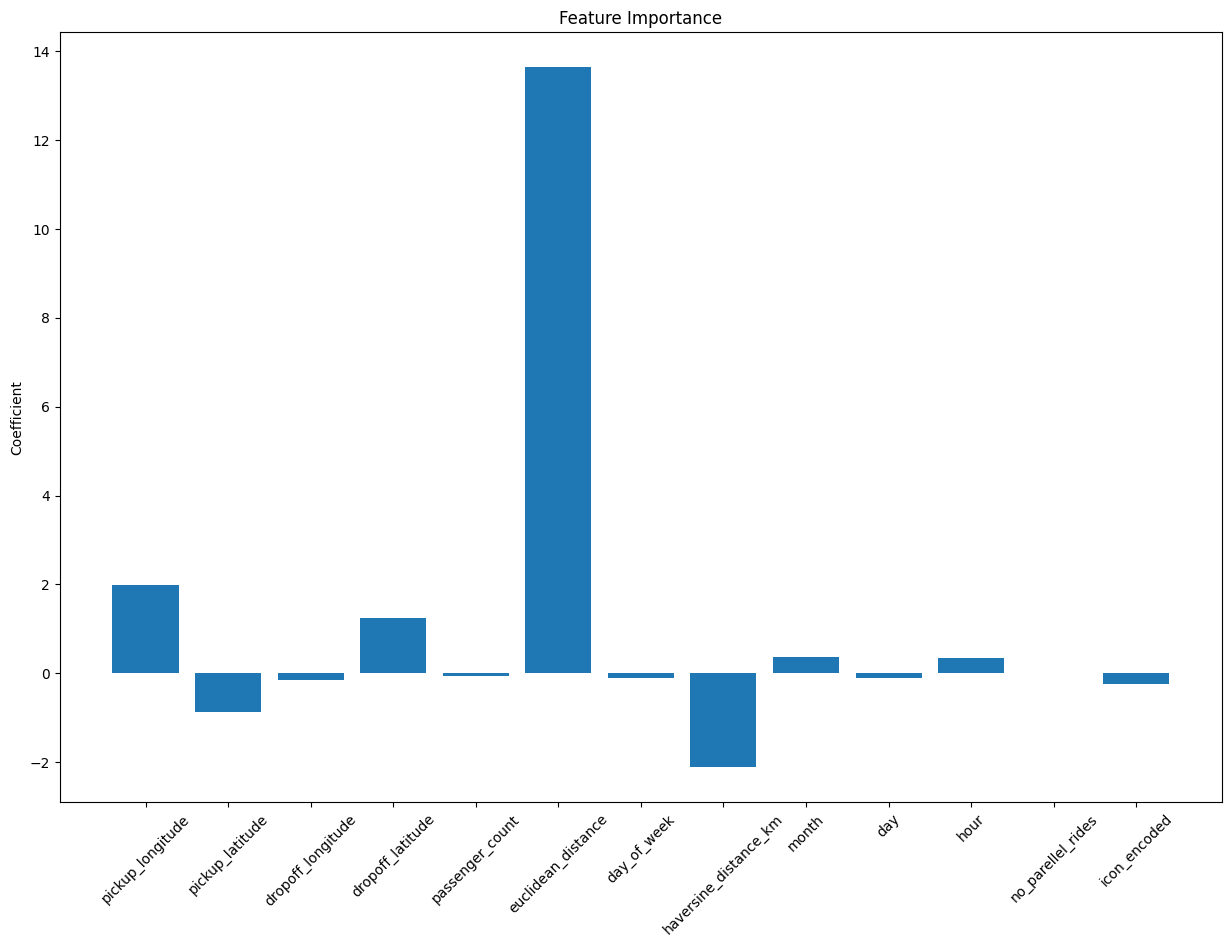

In [ ]:
# Plot the coefficient
plt.figure(figsize=(15,10))
plt.bar(X.columns, model.coef_)
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.title('Feature Importance')
plt.show()

Compare to Our previous model which used only one latent variable, adding the weather condition as a second latent variable causes, the model's performance to improve slightly.

## HyperParameter Tunning and Cross Validation

Best Parameters: {'alpha': 0.01, 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.01}
SGDRegressor(alpha=0.01, penalty='l1', tol=0.01)
Mean Squared Error (MSE): 91.513823
Mean Absolute Error (MAE): 4.701273
R-squared (R2): 0.520634


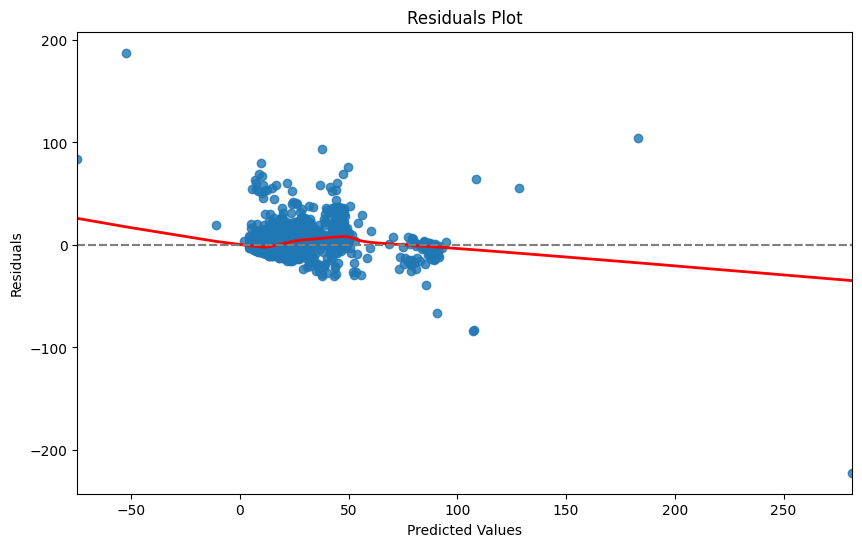

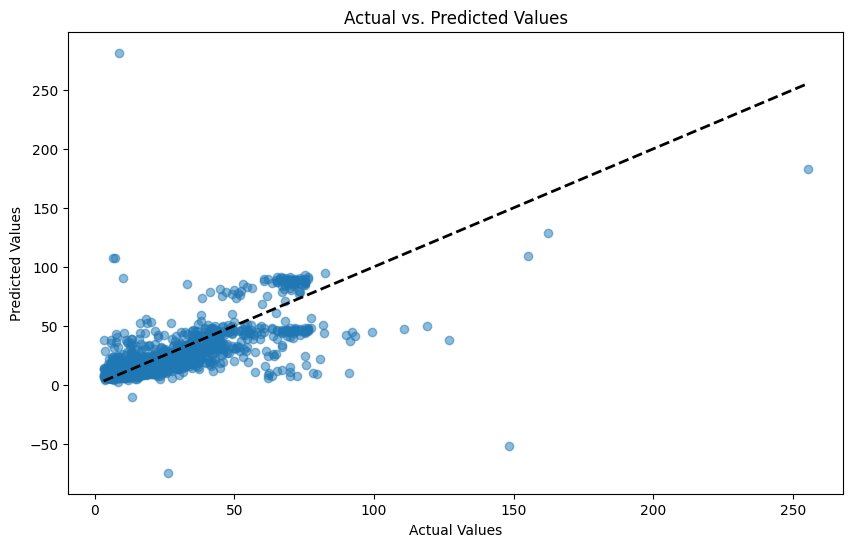

In [ ]:
#code generated by chatgpt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import train_test_split
# Define the parameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [1000, 2000, 3000],
    'tol': [1e-1, 1e-2, 1e-3],
    'penalty': ['l1']
}
# Initialize the SGDRegressor
sgd_reg = SGDRegressor()

# Set up GridSearchCV, we will be evaluating  parameter based on r2 higher the better
grid_search = GridSearchCV(estimator=sgd_reg, param_grid=param_grid, scoring='r2', cv=5)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Print the best parameters
print(f"Best Parameters: {best_parameters}")

# Evaluate the best model found by GridSearchCV on the test data
best_sgd_reg = grid_search.best_estimator_
print(best_sgd_reg)
y_pred = best_sgd_reg.predict(X_test)
evaluate_regression_model(y_test,y_pred)
plot_res_reg(y_test,y_pred)

Compared to to  the Non CV model this one is very slightly better

# Using a MultiLayer Perceptron Network

In [ ]:
X_train.shape

(20994, 15)

We will be using the same Train test Split we Created earlier

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras

In [ ]:

# Define the model architecture
model = Sequential()
model.add(Dense(64, input_dim=13, activation='relu'))  # Input layer and the first hidden layer with 64 neurons
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))  # Output layer with one neuron since it is regression

# Compile the model, using mean_absolute_error as our loss function
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')



In [ ]:
# Fit the model
history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
442/442 [==============================] - 3s 4ms/step - loss: 2.8621 - val_loss: 1.8402
Epoch 2/10
442/442 [==============================] - 2s 4ms/step - loss: 1.6881 - val_loss: 1.6020
Epoch 3/10
442/442 [==============================] - 1s 3ms/step - loss: 1.5388 - val_loss: 1.4992
Epoch 4/10
442/442 [==============================] - 1s 2ms/step - loss: 1.4679 - val_loss: 1.4694
Epoch 5/10
442/442 [==============================] - 1s 3ms/step - loss: 1.4409 - val_loss: 1.4519
Epoch 6/10
442/442 [==============================] - 1s 3ms/step - loss: 1.4205 - val_loss: 1.4408
Epoch 7/10
442/442 [==============================] - 1s 3ms/step - loss: 1.4064 - val_loss: 1.4404
Epoch 8/10
442/442 [==============================] - 1s 2ms/step - loss: 1.3945 - val_loss: 1.4321
Epoch 9/10
442/442 [==============================] - 1s 3ms/step - loss: 1.3830 - val_loss: 1.4336
Epoch 10/10
442/442 [==============================] - 1s 3ms/step - loss: 1.3790 - val_loss: 1.4202

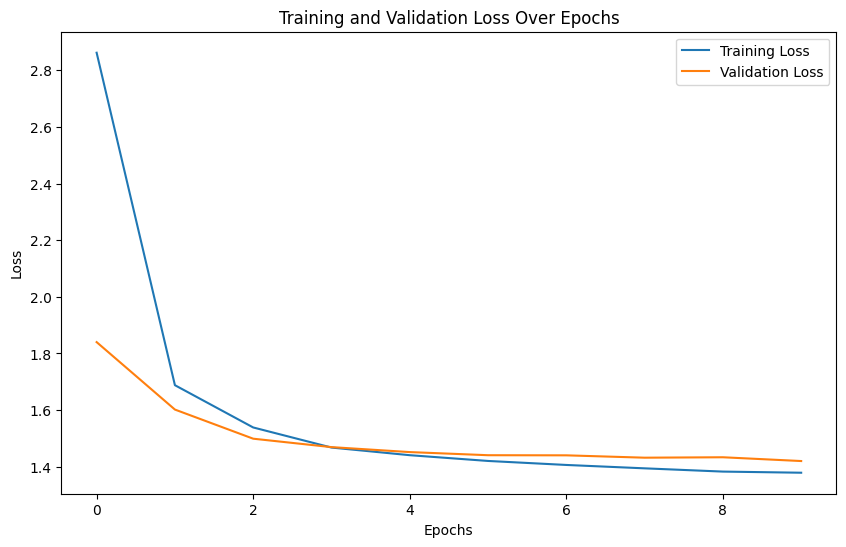

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
evaluate_regression_model(y_test,y_pred)

111/111 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 3.989692
Mean Absolute Error (MAE): 1.420235
R-squared (R2): 0.719029


In [ ]:
y_pred.shape,  y_test.shape

((3535, 1), (3535,))

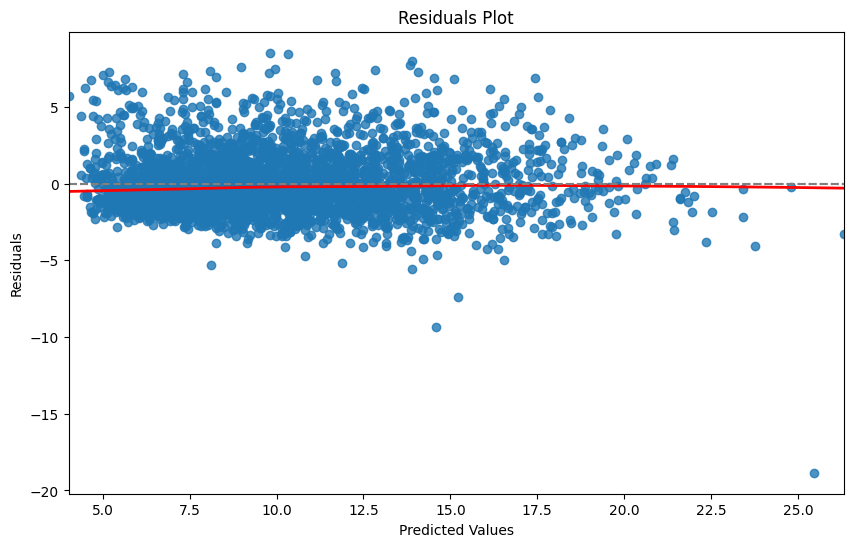

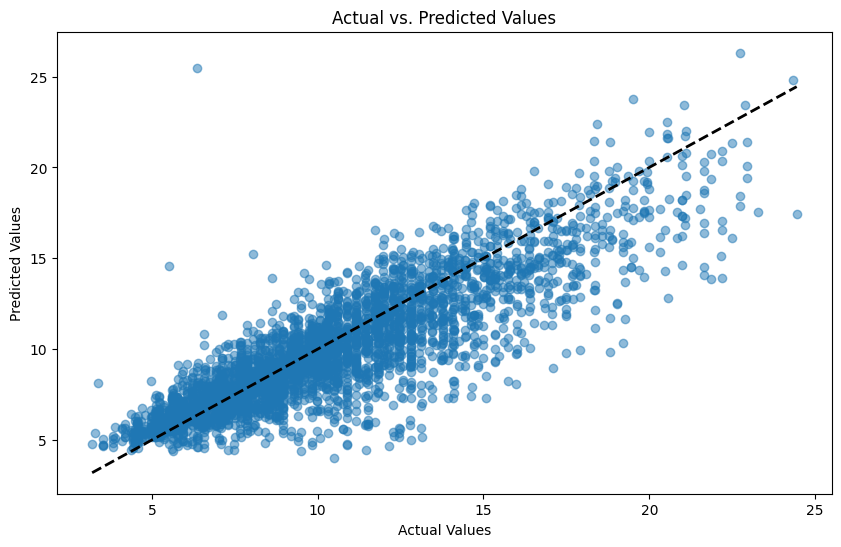

In [ ]:
plot_res_reg(y_test,y_pred.reshape((y_test.shape[0])))

# Muller's Loop: Iteration 1

Let us try to use Muller's Loop to find the best algo and best set of features

In [ ]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
import  time
from pyod.models.knn import KNN

In [ ]:
from sklearn.preprocessing import LabelEncoder
import datetime
#function used for adjusting the price as per inflation
def adjust_fare_inflation(df,inflation=0.025):
  # Current year
  current_year = datetime.datetime.now().year
  # Calculate the difference in years and update the fare
  df['updated_fare_amount'] = df.apply(lambda row: row['fare_amount'] * (1 + inflation) ** (current_year - row['year']), axis=1)
  #getting rid of the old fare amount
  df.drop('fare_amount',axis=1,inplace=True)

def add_no_of_parellel_trips_latent_variable(df):
  # Group by year, month, day, and hour and count the number of occurrences
  group_sizes = df.groupby(['year', 'month', 'day', 'hour']).size().reset_index(name='no_parellel_rides')

  # Merge the group size information back into the original DataFrame
  uber_parellel_rides = pd.merge(df, group_sizes, on=['year', 'month', 'day', 'hour'], how='left')
  return uber_parellel_rides

def remove_outliers(df):
  #code generated by chatGPT
  # Assuming 'df' is your DataFrame and 'feature_columns' is a list of feature column names
  X = df.drop(['year','date','time','seconds','minutes'],axis=1)

  # Initialize the KNN model for outlier detection
  clf = KNN()

  # Fit the model on the data
  clf.fit(X)

  # Get the outlier scores for each data point
  outlier_scores = clf.decision_scores_

  # You can use a threshold to classify data points as outliers or inliers
  # For example, let's use the mean of the outlier scores as the threshold
  threshold = outlier_scores.mean()

  # Mark data points as outliers if their scores are greater than the threshold
  is_outlier = outlier_scores > threshold

  # Filter out the outliers from the DataFrame
  cleaned_df = df[~is_outlier]

  print(f"Original DataFrame size: {df.shape}")
  print(f"Cleaned DataFrame size: {cleaned_df.shape}")
  return cleaned_df

def join_weather_data(uber_data,weather_data):
  df_weather = weather_data[['datetime','icon']]

  #performing label encoding on icon

  # Initialize the LabelEncoder
  label_encoder = LabelEncoder()

  # Fit the label encoder and transform the 'icon' column
  df_weather['icon_encoded'] = label_encoder.fit_transform(df_weather['icon'])
  # Perform an inner join on the 'date' column
  df_weather2 = df_weather[['datetime','icon_encoded']]
  #renaming column so the join operation can performed
  df_weather2 = df_weather2.rename({'datetime':'date'},axis=1)
  uber_with_weather = pd.merge(uber_data, df_weather2, on='date', how='inner')
  return uber_with_weather

def preprocess_data(uber,weather):
  #adjust the price for inflation
  adjust_fare_inflation(uber)
  #add parellel rides information
  uber_parelle_rides = add_no_of_parellel_trips_latent_variable(uber)
  #addweather information
  uber_with_weather=join_weather_data(uber_parelle_rides,weather)
  return uber_parelle_rides,uber_with_weather


def split_data(df):
  X = merged_uber_parelle_rides_weather.drop(['year','updated_fare_amount','date','time'],axis=1)
  scaler = StandardScaler()
  # Fit the scaler to the data and transform it
  X_scaled = scaler.fit_transform(X)
  y = merged_uber_parelle_rides_weather['updated_fare_amount']
  # Split the dataset into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)
  return X_train, X_test, y_train, y_test


def evaluate_regression_model(y_test,y_pred):
  # Evaluating the model using different techniques
  # Calculate metrics
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  # Print metrics
  print(f"Mean Squared Error (MSE): {mse:f}")
  print(f"Mean Absolute Error (MAE): {mae:f}")
  print(f"R-squared (R2): {r2:f}")
  return mse,mae,r2


In [ ]:
#Initialize an MLP Regressor
mlp = Sequential()
mlp.add(Dense(64, input_dim=14, activation='relu'))  # Input layer and the first hidden layer with 64 neurons
mlp.add(Dense(64, activation='relu'))  # Second hidden layer with 32 neurons
mlp.add(Dense(16, activation='relu'))  # Second hidden layer with 32 neurons
mlp.add(Dense(1, activation='linear'))  # Output layer with one neuron since it is regression
# Compile the model, using mean_sqaured_error as our loss function
mlp.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Initialize XGBRegressor
xg_reg = XGBRegressor(objective ='reg:squarederror',
                          colsample_bytree = 0.3,
                          learning_rate = 0.1,
                          max_depth = 5,
                          alpha = 10,
                          n_estimators = 10)

#Initialize Linear Regressor
lr = LinearRegression()

#Initialize RandomForest Regressor

rf = RandomForestRegressor(n_estimators=100,  # Number of trees in the forest
                               max_depth=None,    # Maximum depth of the trees
                               random_state=42)   # Seed for reproducibility

# Initialize the KNN Regressor
knn_reg = KNeighborsRegressor(n_neighbors=5)

names = ["MLP Regressor", "Linear Regression", "Random Forest Regressor",
         "KNN Regressor", "XGBoost Regressor"]
#an array of all regressors
regressors =[mlp,lr,rf,knn_reg,xg_reg]
#variable to save the output all runs
mullers_iterations={name:[] for name in names}

def initialize_mlp(X):
    #hnadling different input dim
    #Initialize an MLP Regressor
    mlp = Sequential()
    mlp.add(Dense(64, input_dim=X.shape[1], activation='relu'))
    mlp.add(Dense(64, activation='relu'))
    mlp.add(Dense(16, activation='relu'))
    mlp.add(Dense(1, activation='linear'))
    # Compile the model, using mean_sqaured_error as our loss function
    mlp.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    #update the regressors
    regressors.pop(0)
    regressors.insert(0,mlp)

def run_muller_loop():
  initialize_mlp(X)
  min_mse = float('inf')
  max_class = ''
  # iterate over regressors
  for name, reg in zip(names, regressors):
      start_time = time.time()
      if name!='MLP Regressor':
        reg.fit(X_train, y_train)
      else:
        #special case for handling MLP using Keras
        reg.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

      y_pred = reg.predict(X_test)
      mse,mae,r2=evaluate_regression_model(y_test,y_pred)
      print(f'For {name} MSE {mse}, Training Time = {(time.time() - start_time):2f}')
      mullers_iterations[name].append({'MSE':mse,'MAE':mae,'R2':r2})
      if mse < min_mse:
          reg_best = reg
          min_mse = mse
          max_class = name

  print(80*'-' )
  print('Best --> Regerssor = %s, Score (test, MSE) = %.2f' %(max_class, min_mse))
  return reg_best

In [ ]:
#load uber data
df1 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/uber_clean_preclustering_datetime_split.csv')
df2 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/synthetic_uber_data_2016.csv')
df3 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/synthetic_uber_data_2017.csv')

#combining all 3 uber data
uber_data = pd.concat([df1,df2,df3],axis=0)
uber_data.reset_index(drop=True,inplace=True)


In [ ]:
#removing outliers from uber data

In [ ]:
#load the weather data
weather_data = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/combined_weather_nyc_2009_2017.csv')

## Running with any data amalgation without latent variables

In [ ]:
#removing outlier from uber
cleaned_uber = remove_outliers(uber_data)
#performing all the necessary preprocessing steps
uber_data_parellel_rides,uber_data_parellel_rides_weather=preprocess_data(cleaned_uber,weather_data)

Original DataFrame size: (28243, 17)
Cleaned DataFrame size: (18705, 17)


<ipython-input-107-4b09e53e875e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['updated_fare_amount'] = df.apply(lambda row: row['fare_amount'] * (1 + inflation) ** (current_year - row['year']), axis=1)
<ipython-input-107-4b09e53e875e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('fare_amount',axis=1,inplace=True)
<ipython-input-107-4b09e53e875e>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [ ]:
#performing a train test split
X = cleaned_uber.drop(['year','updated_fare_amount','date','time','seconds','minutes'],axis=1)
#scaling the data
scaler = StandardScaler()
# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X)
y = cleaned_uber['updated_fare_amount']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)

In [ ]:
X_train.shape

(22594, 11)

In [ ]:
#running the first iteration of muller's loop
reg_best=run_muller_loop()

Epoch 1/10
468/468 [==============================] - 2s 3ms/step - loss: 17.6117 - val_loss: 7.3362
Epoch 2/10
468/468 [==============================] - 1s 2ms/step - loss: 5.7063 - val_loss: 5.1975
Epoch 3/10
468/468 [==============================] - 1s 3ms/step - loss: 4.6428 - val_loss: 4.7540
Epoch 4/10
468/468 [==============================] - 3s 7ms/step - loss: 4.4134 - val_loss: 4.6378
Epoch 5/10
468/468 [==============================] - 2s 3ms/step - loss: 4.2680 - val_loss: 4.6378
Epoch 6/10
468/468 [==============================] - 1s 3ms/step - loss: 4.1735 - val_loss: 4.6064
Epoch 7/10
468/468 [==============================] - 1s 3ms/step - loss: 4.1231 - val_loss: 4.4496
Epoch 8/10
468/468 [==============================] - 1s 3ms/step - loss: 4.0769 - val_loss: 4.4497
Epoch 9/10
468/468 [==============================] - 1s 3ms/step - loss: 4.0023 - val_loss: 4.3853
Epoch 10/10
117/117 [==============================] - 0s 1ms/step
Mean Squared Error (MSE): 4.2925

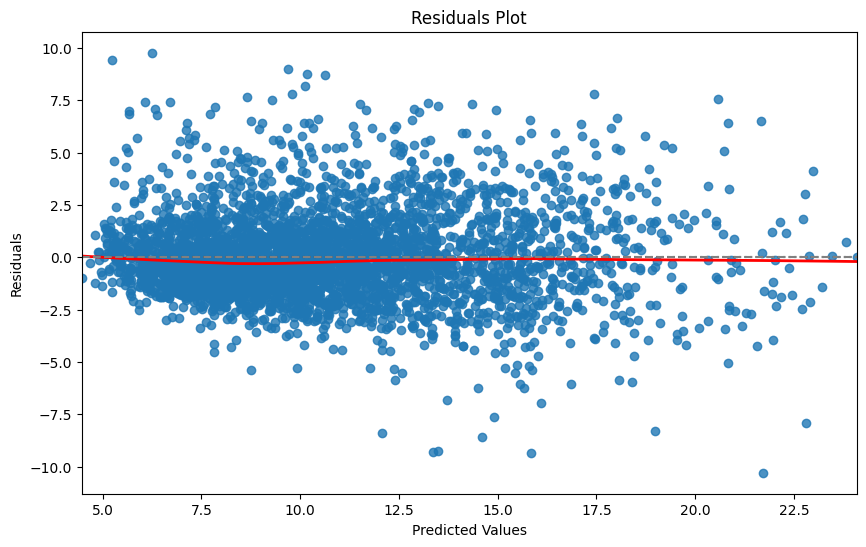

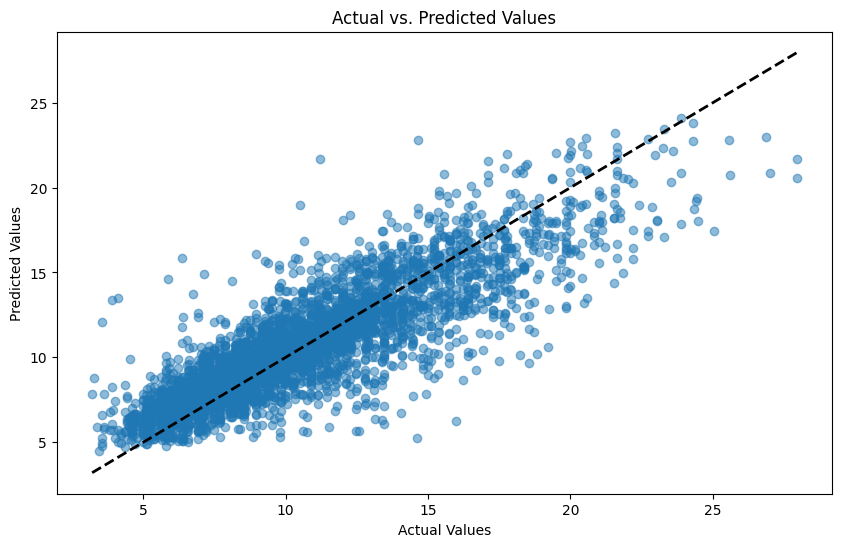

In [ ]:
y_pred = reg_best.predict(X_test)
plot_res_reg(y_test,y_pred)

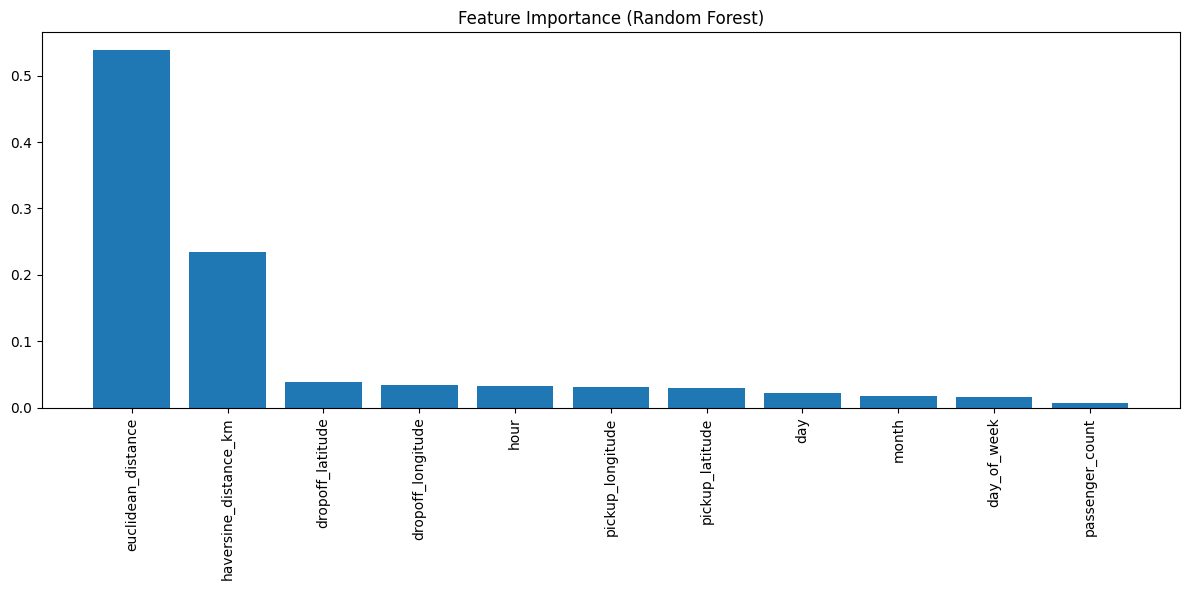

In [ ]:
feature_importances_rf = rf.feature_importances_
# Sort the feature importance in descending order
sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(X.shape[1]), feature_importances_rf[sorted_indices_rf], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices_rf], rotation=90)
plt.tight_layout()
plt.show()

# Muller Loop : Iteration 2, using parellel trip as latent variables along with previous used variables

In [ ]:
#performing a train test split
X = uber_data_parellel_rides.drop(['year','updated_fare_amount','date','time','seconds','minutes'],axis=1)
#scaling the data
scaler = StandardScaler()
# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X)
y = uber_data_parellel_rides['updated_fare_amount']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)

In [ ]:
#running the second iteration of muller's loop
reg_best=run_muller_loop()

Epoch 1/10
468/468 [==============================] - 2s 3ms/step - loss: 16.1926 - val_loss: 7.9385
Epoch 2/10
468/468 [==============================] - 1s 3ms/step - loss: 6.1244 - val_loss: 5.5407
Epoch 3/10
468/468 [==============================] - 1s 3ms/step - loss: 4.8477 - val_loss: 4.8807
Epoch 4/10
468/468 [==============================] - 1s 3ms/step - loss: 4.5108 - val_loss: 4.6918
Epoch 5/10
468/468 [==============================] - 2s 4ms/step - loss: 4.3749 - val_loss: 4.6431
Epoch 6/10
468/468 [==============================] - 2s 3ms/step - loss: 4.3186 - val_loss: 4.5345
Epoch 7/10
468/468 [==============================] - 1s 3ms/step - loss: 4.1942 - val_loss: 4.5847
Epoch 8/10
468/468 [==============================] - 1s 2ms/step - loss: 4.1021 - val_loss: 4.3958
Epoch 9/10
468/468 [==============================] - 1s 3ms/step - loss: 4.0402 - val_loss: 4.4413
Epoch 10/10
117/117 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 4.3358

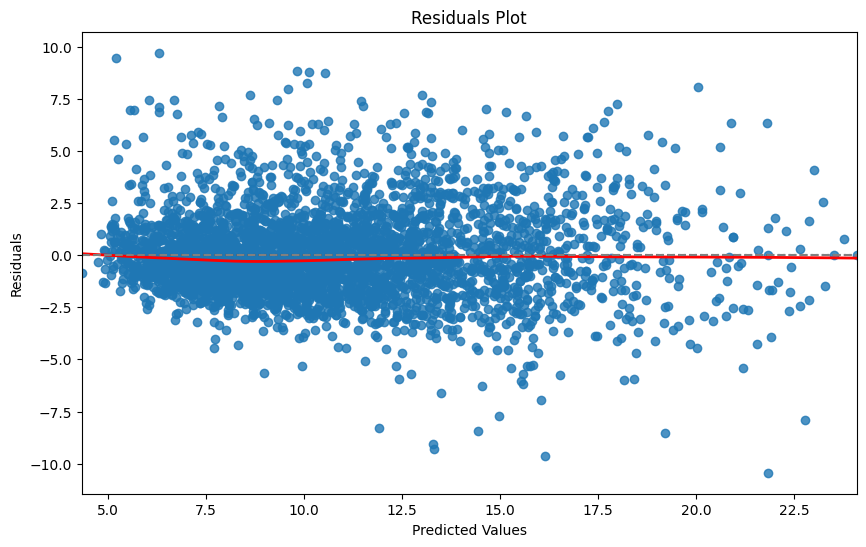

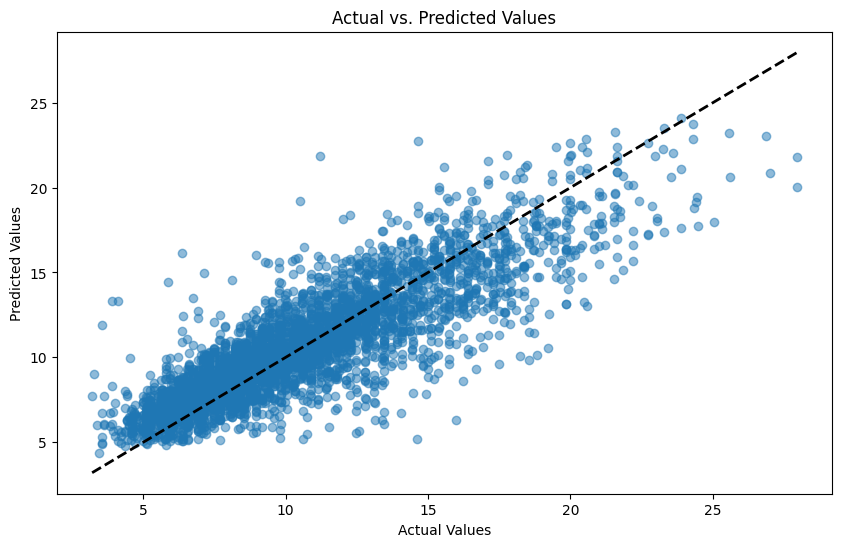

In [ ]:
y_pred = reg_best.predict(X_test)
plot_res_reg(y_test,y_pred)

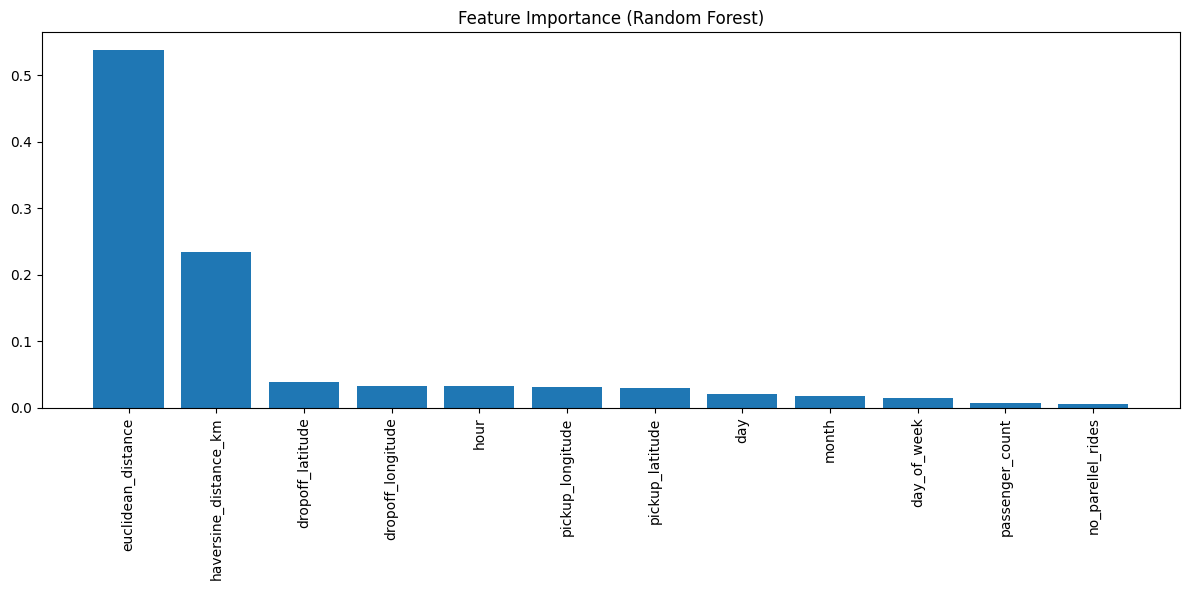

In [ ]:
feature_importances_rf = rf.feature_importances_
# Sort the feature importance in descending order
sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(X.shape[1]), feature_importances_rf[sorted_indices_rf], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices_rf], rotation=90)
plt.tight_layout()
plt.show()

Now based on the article we discovered the number of parellel rides should have impacted the result to a much greater extent then it is impacting right now, this can be due to that for most of out data the value of number of parellel rides is 1, ths=is reduces the overall varitey of data for traning

Between iteration 1 and 2 the performance of the best model remains the same

## Side Quest: Using SMOTE to address the issue

In [ ]:

from imblearn.over_sampling import SMOTE


#firstly we will set no_parellel_ride as our target variable and fit SMOTE to it
X= uber_data_parellel_rides.drop(['date','time','seconds','minutes','no_parellel_rides'],axis=1)
Y = uber_data_parellel_rides['no_parellel_rides']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the SMOTE object
smote = SMOTE(random_state=42)
# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X, Y)

# Check the class distribution after SMOTE
print(f"Original class distribution: {Y.value_counts()}")
print(f"SMOTE class distribution: {pd.Series(y_train_smote).value_counts()}")


Original class distribution: 1    12405
2     4912
3     1149
4      208
5       25
6        6
Name: no_parellel_rides, dtype: int64
SMOTE class distribution: 4    12405
1    12405
2    12405
3    12405
5    12405
6    12405
Name: no_parellel_rides, dtype: int64


In [ ]:
#now we will combine the smote data to make the main data
balanced_data = X_train_smote.copy()
balanced_data['no_parellel_ride'] =y_train_smote
#performing data split and training
#performing a train test split
X = balanced_data.drop(['year','updated_fare_amount'],axis=1)
#scaling the data
scaler = StandardScaler()
# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X)
y = balanced_data['updated_fare_amount']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)

In [ ]:
best_reg=run_muller_loop()

Epoch 1/10
1861/1861 [==============================] - 14s 6ms/step - loss: 7.2722 - val_loss: 2.8160
Epoch 2/10
1861/1861 [==============================] - 13s 7ms/step - loss: 2.5323 - val_loss: 2.2735
Epoch 3/10
1861/1861 [==============================] - 11s 6ms/step - loss: 2.2736 - val_loss: 2.1693
Epoch 4/10
1861/1861 [==============================] - 9s 5ms/step - loss: 2.1478 - val_loss: 2.0217
Epoch 5/10
1861/1861 [==============================] - 11s 6ms/step - loss: 2.0453 - val_loss: 2.0100
Epoch 6/10
1861/1861 [==============================] - 7s 4ms/step - loss: 1.9647 - val_loss: 1.9381
Epoch 7/10
1861/1861 [==============================] - 10s 5ms/step - loss: 1.9232 - val_loss: 1.8769
Epoch 8/10
1861/1861 [==============================] - 8s 4ms/step - loss: 1.8521 - val_loss: 1.8247
Epoch 9/10
1861/1861 [==============================] - 9s 5ms/step - loss: 1.8465 - val_loss: 1.9137
Epoch 10/10
466/466 [==============================] - 1s 2ms/step
Mean Squar

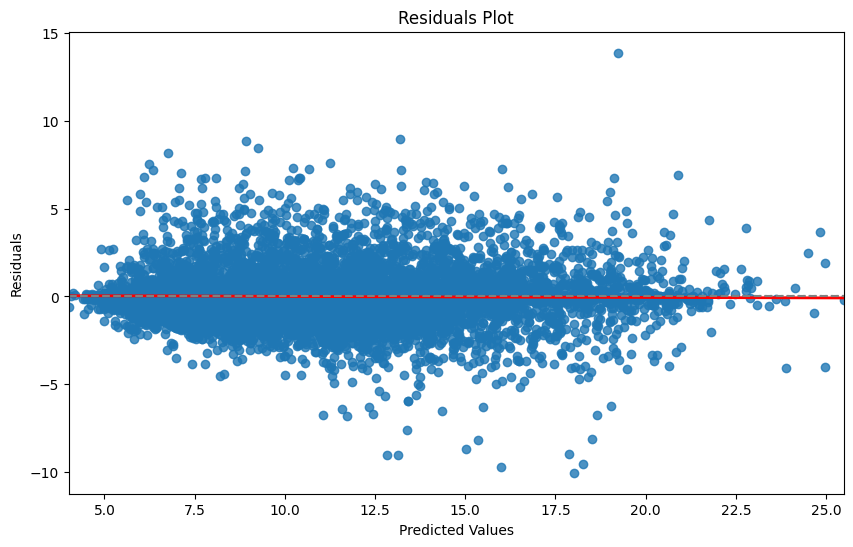

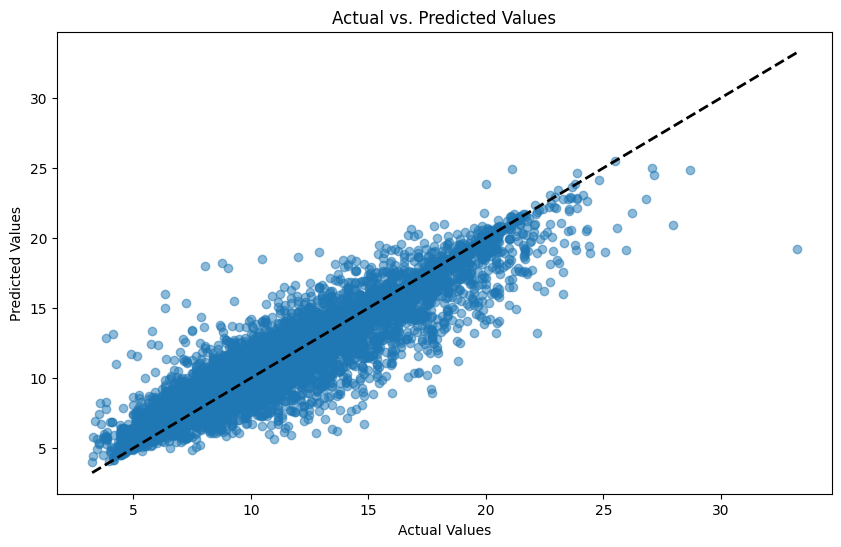

In [ ]:
y_pred = reg_best.predict(X_test)
plot_res_reg(y_test,y_pred)

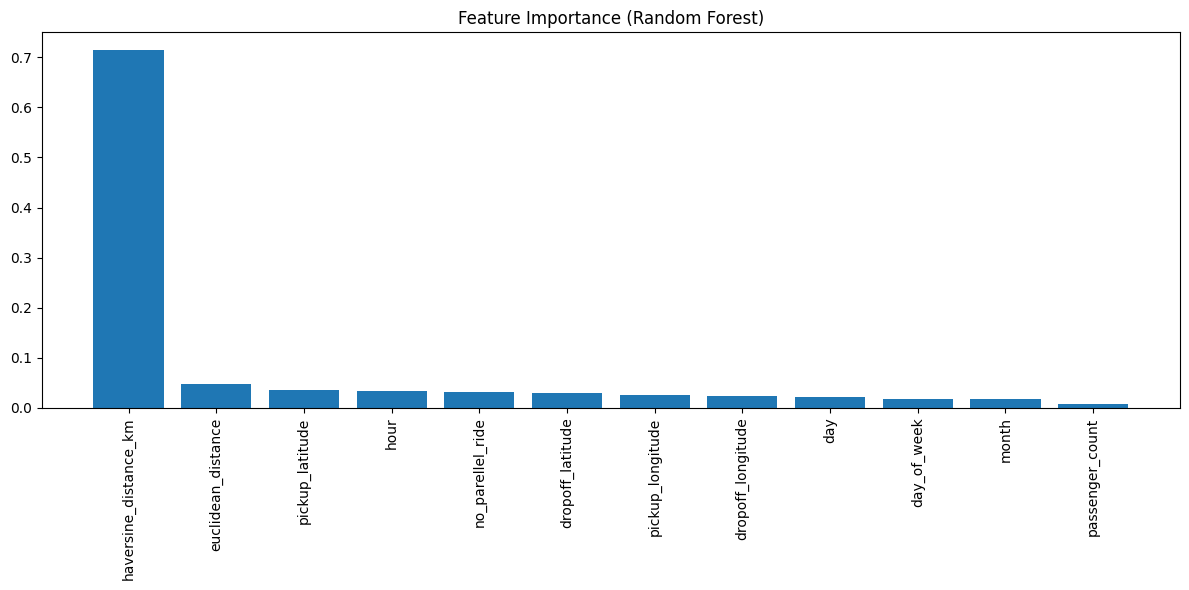

In [ ]:
feature_importances_rf = rf.feature_importances_
# Sort the feature importance in descending order
sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(X.shape[1]), feature_importances_rf[sorted_indices_rf], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices_rf], rotation=90)
plt.tight_layout()
plt.show()

After applying SMOTE the over all performance has increased drastically we went from an MSE value of 4.28 to 1.4. And we can see the feature importance of number of parellel rides has also increased.

# Muller Loop Iteration 3: Using parellel trips along with weather conditions as latent variables

In [ ]:
#performing a train test split
X = uber_data_parellel_rides_weather.drop(['year','updated_fare_amount','date','time','seconds','minutes'],axis=1)
#scaling the data
scaler = StandardScaler()
# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X)
y = uber_data_parellel_rides_weather['updated_fare_amount']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)

In [ ]:
#running the third iteration of muller's loop
reg_best=run_muller_loop()

Epoch 1/10
468/468 [==============================] - 2s 3ms/step - loss: 17.4373 - val_loss: 5.9892
Epoch 2/10
468/468 [==============================] - 1s 3ms/step - loss: 5.9864 - val_loss: 4.9812
Epoch 3/10
468/468 [==============================] - 1s 3ms/step - loss: 4.9835 - val_loss: 4.5030
Epoch 4/10
468/468 [==============================] - 1s 2ms/step - loss: 4.6741 - val_loss: 4.4709
Epoch 5/10
468/468 [==============================] - 1s 2ms/step - loss: 4.5551 - val_loss: 4.2361
Epoch 6/10
468/468 [==============================] - 1s 3ms/step - loss: 4.4952 - val_loss: 4.1674
Epoch 7/10
468/468 [==============================] - 2s 3ms/step - loss: 4.4181 - val_loss: 4.1094
Epoch 8/10
468/468 [==============================] - 2s 4ms/step - loss: 4.3865 - val_loss: 4.1318
Epoch 9/10
468/468 [==============================] - 2s 4ms/step - loss: 4.3334 - val_loss: 4.0666
Epoch 10/10
117/117 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 4.0676

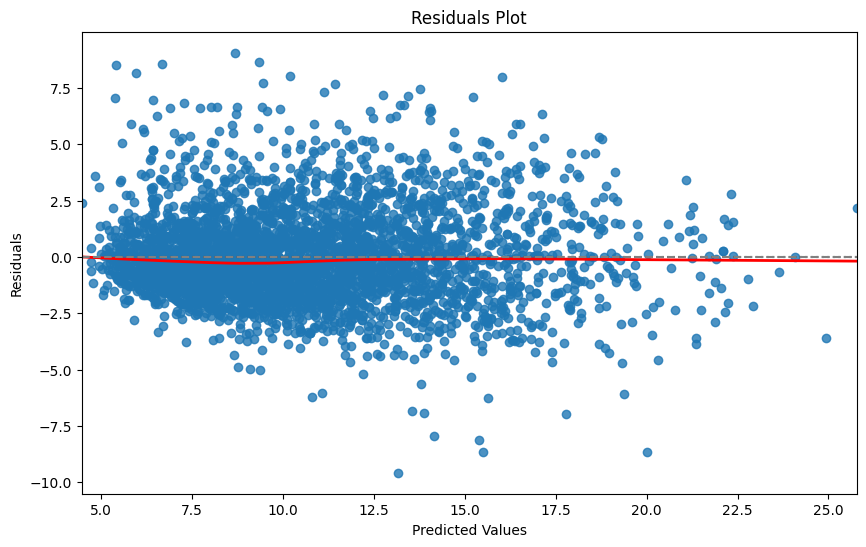

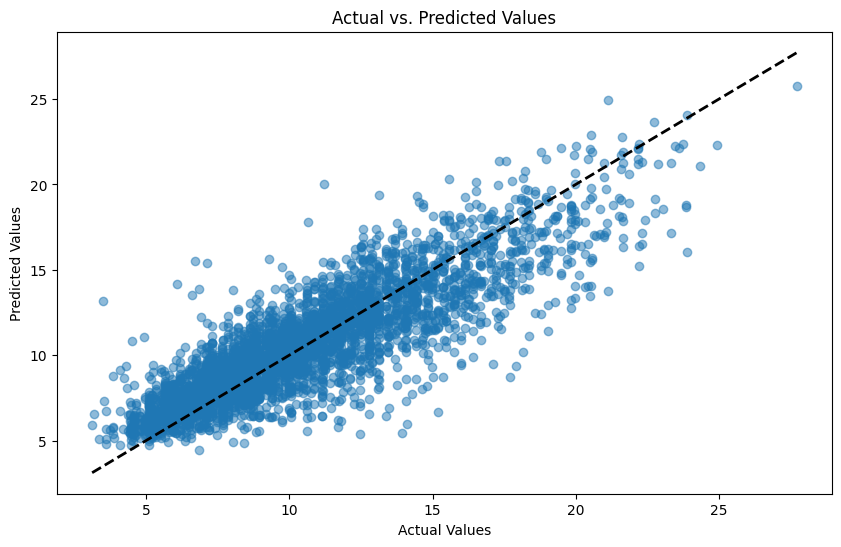

In [ ]:
y_pred = reg_best.predict(X_test)
plot_res_reg(y_test,y_pred)

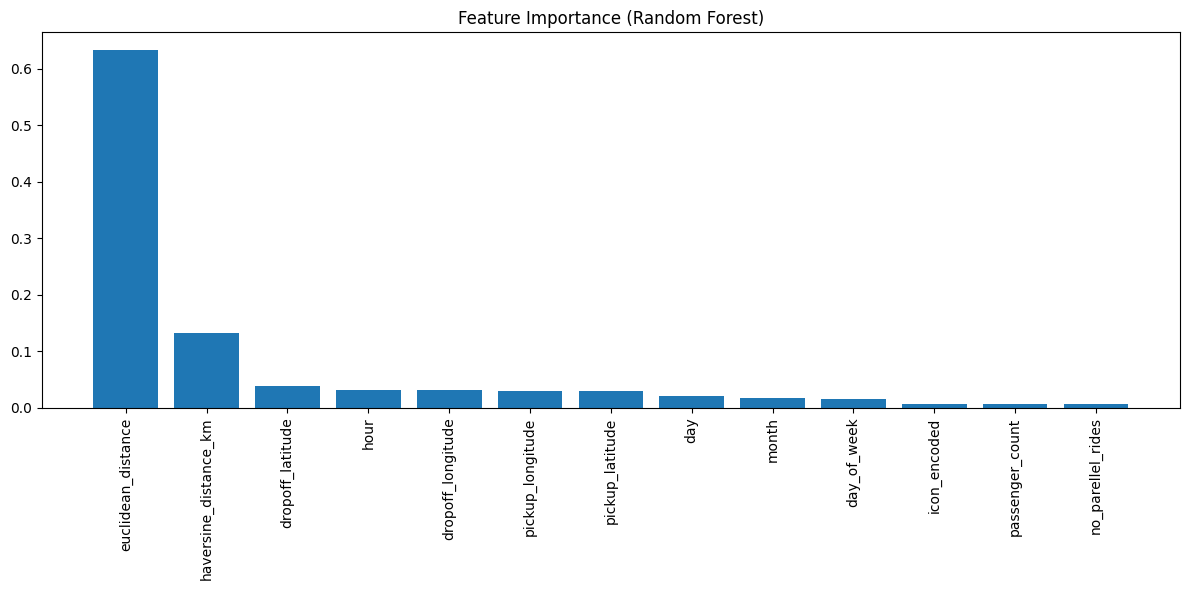

In [ ]:
feature_importances_rf = rf.feature_importances_
# Sort the feature importance in descending order
sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(X.shape[1]), feature_importances_rf[sorted_indices_rf], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices_rf], rotation=90)
plt.tight_layout()
plt.show()

When we added the weather condition (latent variable) to our data we can see that the performance of the best model increase, the lowesr MSE goes from 4.27 to 3.9. However the performance is worse when we used a balanced data set in terms of number of records with different number of parellel rides in the Side quest of Muller loop iteration 2

## Side Quest: Using the balanced dataset where the distribution of both latent variables (parellel rides and weather) are balanced.

First we'll balanced out the parellel rides data, and then we will balance out the weather data

In [ ]:
#uisng the balanced_data generated eralier to generated dalanced weather data
#Joining the balanced_data with weather

#firstly we will set no_parellel_ride as our target variable and fit SMOTE to it

X= uber_data_parellel_rides_weather.drop(['date','time','seconds','minutes','no_parellel_rides'],axis=1)
Y = uber_data_parellel_rides_weather['no_parellel_rides']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Initialize the SMOTE object
smote = SMOTE(random_state=42)
# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X, Y)

# Check the class distribution after SMOTE
print(f"Original class distribution: {Y.value_counts()}")
print(f"SMOTE class distribution: {pd.Series(y_train_smote).value_counts()}")

#combining them
#now we will combine the smote data to make the main data
balanced_data_trips = X_train_smote.copy()
balanced_data_trips['no_parellel_ride'] =y_train_smote



Original class distribution: 1    12405
2     4912
3     1149
4      208
5       25
6        6
Name: no_parellel_rides, dtype: int64
SMOTE class distribution: 4    12405
1    12405
2    12405
3    12405
5    12405
6    12405
Name: no_parellel_rides, dtype: int64


In [ ]:
#now on this balanced data we will apply SMOTE again but this time our target will be icon encoded (which reprents weather)
X= balanced_data_trips.drop(['icon_encoded'],axis=1)
Y = balanced_data_trips['icon_encoded']

# Initialize the SMOTE object
smote = SMOTE(random_state=42,k_neighbors=2)
# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X, Y)

#combining them
#now we will combine the smote data to make the main data
balanced_data_trips_weather = X_train_smote.copy()
balanced_data_trips_weather['icon_encoded'] =y_train_smote

# Check the class distribution after SMOTE
print(f"Original class distribution: {Y.value_counts()}")
print(f"SMOTE class distribution: {pd.Series(y_train_smote).value_counts()}")


Original class distribution: 3    29313
4    21867
0    20163
1     1253
5      979
2      852
6        3
Name: icon_encoded, dtype: int64
SMOTE class distribution: 0    29313
4    29313
3    29313
5    29313
1    29313
2    29313
6    29313
Name: icon_encoded, dtype: int64


In [ ]:
#performing a train test split
X = balanced_data_trips_weather.drop(['year','updated_fare_amount'],axis=1)
#scaling the data
scaler = StandardScaler()
# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X)
y = balanced_data_trips_weather['updated_fare_amount']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)

In [ ]:
reg_best = run_muller_loop()

Epoch 1/10
5130/5130 [==============================] - 15s 3ms/step - loss: 3.6652 - val_loss: 1.5401
Epoch 2/10
5130/5130 [==============================] - 13s 2ms/step - loss: 1.4316 - val_loss: 1.2250
Epoch 3/10
5130/5130 [==============================] - 14s 3ms/step - loss: 1.2538 - val_loss: 1.1266
Epoch 4/10
5130/5130 [==============================] - 14s 3ms/step - loss: 1.1560 - val_loss: 1.0578
Epoch 5/10
5130/5130 [==============================] - 14s 3ms/step - loss: 1.0999 - val_loss: 1.0483
Epoch 6/10
5130/5130 [==============================] - 14s 3ms/step - loss: 1.0550 - val_loss: 0.9681
Epoch 7/10
5130/5130 [==============================] - 14s 3ms/step - loss: 1.0178 - val_loss: 0.9867
Epoch 8/10
5130/5130 [==============================] - 14s 3ms/step - loss: 0.9846 - val_loss: 0.9507
Epoch 9/10
5130/5130 [==============================] - 14s 3ms/step - loss: 0.9698 - val_loss: 0.9612
Epoch 10/10
1283/1283 [==============================] - 2s 2ms/step
Mean

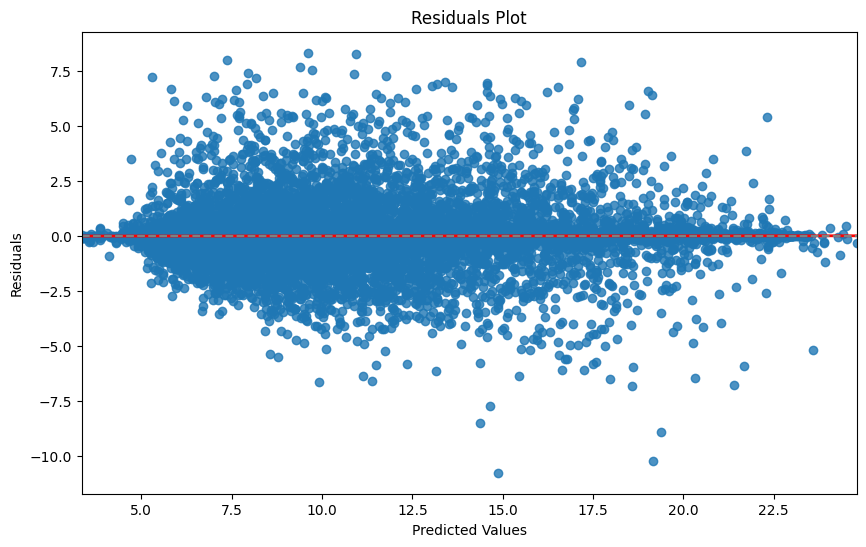

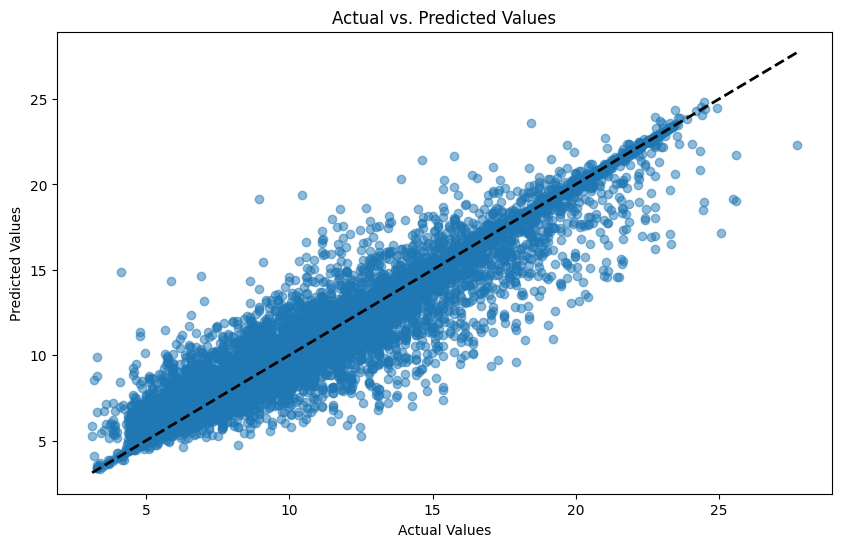

In [ ]:
y_pred = reg_best.predict(X_test)
plot_res_reg(y_test,y_pred)

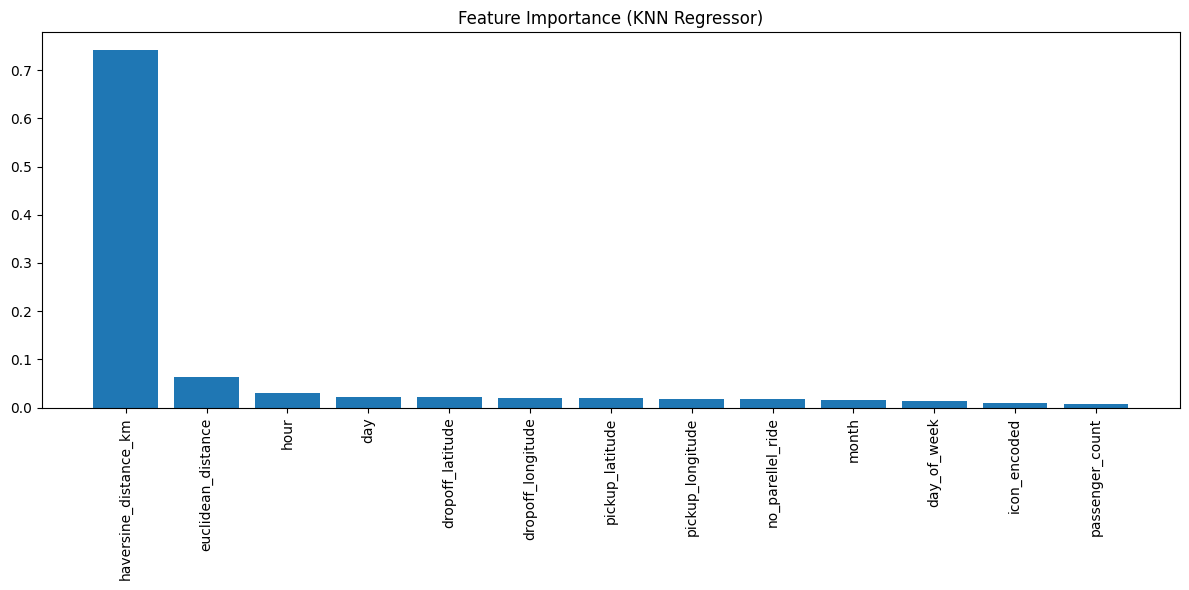

In [ ]:
feature_importances_rf = rf.feature_importances_
# Sort the feature importance in descending order
sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importance (KNN Regressor)')
plt.bar(range(X.shape[1]), feature_importances_rf[sorted_indices_rf], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices_rf], rotation=90)
plt.tight_layout()
plt.show()

The overall performance of the best model has increase drastically as MSE IS 0.53. However the feature importance the weather_data (icon_encoded column) has decrease, implying that the imrpoved performance could be due to us working with a large volumne of synthetic data which follows a certain distribution.

# Conclusion

In [ ]:
#code generated by ChatGPT
import pandas as pd

# Assuming mullers_iterations is a dictionary with the required structure

# Create a DataFrame from the dictionary
df = pd.DataFrame.from_dict(mullers_iterations, orient='index')

# Transpose the DataFrame so that each row corresponds to a model
df = df.transpose()

# Set column names if known, otherwise use default integer index
column_names = ['MSE', 'MAE', 'R2']
if len(df.columns) == len(column_names):
    df.columns = column_names

# Create a hierarchical DataFrame with the desired structure
iteration_names = ['No latent Variable', 'Parallel Rides', 'Parellel Rides SMOTE','Parallel Rides + Weather','Parallel Rides SMOTE + Weather SMOTE']
multi_index = pd.MultiIndex.from_product([list(mullers_iterations.keys()), iteration_names], names=['Algorithm', 'Iteration'])
multi_columns = pd.MultiIndex.from_product([['MSE', 'MAE', 'R2']], names=['Metric'])

hierarchical_df = pd.DataFrame(index=multi_index, columns=multi_columns)

# Populate the DataFrame with the data
for algorithm, results in mullers_iterations.items():
    for iteration, metrics in enumerate(results):
        for metric, value in metrics.items():
            hierarchical_df.loc[(algorithm, iteration_names[iteration]), (metric)] = value

# Drop columns with all NaN values
hierarchical_df = hierarchical_df.dropna(axis=1, how='all')

hierarchical_df


Metric                                                              MSE  \
Algorithm               Iteration                                         
MLP Regressor           No latent Variable                     4.292526   
                        Parallel Rides                         4.335815   
                        Parellel Rides SMOTE                   1.863715   
                        Parallel Rides + Weather               4.067611   
                        Parallel Rides SMOTE + Weather SMOTE    0.89271   
Linear Regression       No latent Variable                     5.018294   
                        Parallel Rides                         5.015565   
                        Parellel Rides SMOTE                   4.170565   
                        Parallel Rides + Weather               4.514431   
                        Parallel Rides SMOTE + Weather SMOTE   3.290112   
Random Forest Regressor No latent Variable                      4.27687   
                        Parallel Rides                         4.278022   
                        Parellel Rides SMOTE                    1.40149   
                        Parallel Rides + Weather                3.92076   
                        Parallel Rides SMOTE + Weather SMOTE   0.544726   
KNN Regressor           No latent Variable                     5.180429   
                        Parallel Rides                         5.253796   
                        Parellel Rides SMOTE                   1.433072   
                        Parallel Rides + Weather               5.138435   
                        Parallel Rides SMOTE + Weather SMOTE     0.5285   
XGBoost Regressor       No latent Variable                     7.904883   
                        Parallel Rides                        10.477343   
                        Parellel Rides SMOTE                   8.039946   
                        Parallel Rides + Weather               8.972671   
                        Parallel Rides SMOTE + Weather SMOTE   7.076375   

Metric                                                             MAE  \
Algorithm               Iteration                                        
MLP Regressor           No latent Variable                    1.525665   
                        Parallel Rides                        1.509394   
                        Parellel Rides SMOTE                  0.891903   
                        Parallel Rides + Weather                1.5104   
                        Parallel Rides SMOTE + Weather SMOTE  0.550027   
Linear Regression       No latent Variable                    1.679858   
                        Parallel Rides                        1.680048   
                        Parellel Rides SMOTE                  1.593153   
                        Parallel Rides + Weather              1.619754   
                        Parallel Rides SMOTE + Weather SMOTE   1.33304   
Random Forest Regressor No latent Variable                    1.544684   
                        Parallel Rides                        1.543178   
                        Parellel Rides SMOTE                  0.625961   
                        Parallel Rides + Weather              1.493519   
                        Parallel Rides SMOTE + Weather SMOTE  0.276914   
KNN Regressor           No latent Variable                    1.715144   
                        Parallel Rides                        1.738429   
                        Parellel Rides SMOTE                  0.582297   
                        Parallel Rides + Weather              1.739614   
                        Parallel Rides SMOTE + Weather SMOTE  0.236255   
XGBoost Regressor       No latent Variable                    2.219654   
                        Parallel Rides                        2.577307   
                        Parellel Rides SMOTE                   2.25453   
                        Parallel Rides + Weather              2.410103   
                        Parallel Rides SMOTE + Wea

Without using Synthetic data for over sampling purpose the best performance we achieved was when we used both the latent variables using Random Forest Regressor , achiving MSE of 1.4 .

When we go down the over sampling route the best performance which we recived was when we used both latent variables, where we first address the issue with parellel rides and use that to address the imbalance with weather data (icon_encoded). We received an MSE of 0.52 using KNN regressor. (Note at this point the dataset have higher propotion of synthetic data than real life data)